<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [26]</a>'.</span>

# Applying XID+CIGALE to Extreme Starbursts
In this notebook, we read in the data files and prepare them for fitting with XID+CIGALE, the SED prior model extension to XID+. Here we focus on sources in [Rowan-Robinson et al. 2018](https://arxiv.org/abs/1704.07783) and claimed to have a star formation rate of $> 10^{3}\mathrm{M_{\odot}yr^{-1}}$

Import required modules

In [1]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs
import seaborn as sns

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import os

In [2]:

emulator_path=['/research/astro/fir/HELP/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210420_log10sfr_uniformAGN_z.npz']
field=['Lockman-SWIRE']

In [3]:
# Parameters
emulator_path = [
    "/research/astro/fir/HELP/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210420_log10sfr_uniformAGN_z.npz"
]
field = ["XMM-LSS"]


In [4]:
try:
    source = [np.int(os.environ['SGE_TASK_ID'])-1]
except:
    source=[26]

In [5]:
#ysb=Table.read('../../../data/MRRfiles/fromPaper.txt', format='ascii')
esb=Table.read('../../../data/MRR2018_tables/{}_sources.csv'.format(field[0]),format='ascii',encoding='utf-8')


In [6]:
priors,_=xidplus.load('./output/{}/prior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'.pkl')

In [7]:
prior_list=Table.read('./output/{}/prior_list_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'.ascii',format='ascii')


In [8]:
z_mu=np.empty((priors[1].nsrc))
z_sig=np.empty((priors[1].nsrc))

for x,i in enumerate(priors[1].ID):
    ind=prior_list['help_id']==str(i)
    z_mu[x]=prior_list['redshift'][ind]
    z_sig[x]=prior_list['redshift_unc'][ind]

    

sfr_mu=1.5*z_mu+1.0
sfr_sig=np.full(priors[1].nsrc,0.5)

agn_frac_mu=np.full(priors[1].nsrc,-1)
agn_frac_sig=np.full(priors[1].nsrc,1)

In [9]:
params_mu=np.vstack((sfr_mu,z_mu)).T
params_sig=np.vstack((sfr_sig,z_sig)).T
params_names=['log10sfr','z']
hier_params={'m_mu':0.8,'m_sig':0.4,'c_mu':-1.0,'c_sig':0.5,'sfr_disp':0.5}


In [10]:
phys_prior=xidplus.hier_prior(priors[1].ID,params_mu,params_sig,params_names,emulator_path[0])

In [11]:
from numpyro.infer import Predictive
from jax import random, vmap
from xidplus.numpyro_fit import SED_prior

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [12]:

## For numpyro to sample from the prior, the data needs to be set to None
import copy
#make a deepcopy of the priors
priors_prior_pred=copy.deepcopy(priors)
#set data to None
for i in range(0,len(priors)):
    priors_prior_pred[i].sim=None

In [13]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = {}, num_samples = 1000,)
prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)

CPU times: user 8.41 s, sys: 88.4 ms, total: 8.49 s
Wall time: 8.43 s


## Fit Real data

In [14]:
import numpyro
from numpyro.diagnostics import summary
import jax.numpy as jnp
from numpyro.infer import NUTS,MCMC
import os
numpyro.set_host_device_count(os.cpu_count())
from operator import attrgetter
nuts_kernel = NUTS(SED_prior.spire_model_CIGALE,init_strategy=numpyro.infer.init_to_feasible())
mcmc = MCMC(nuts_kernel, num_samples=50, num_warmup=500,num_chains=4,chain_method='parallel')
rng_key = random.PRNGKey(0)
mcmc.run(rng_key,priors,phys_prior,hier_params)

  0%|          | 0/550 [00:00<?, ?it/s]

warmup:   0%|          | 1/550 [00:07<1:11:14,  7.79s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   2%|▏         | 11/550 [00:08<49:02,  5.46s/it, 1023 steps of size 2.36e-03. acc. prob=0.56]

warmup:   2%|▏         | 13/550 [00:08<34:41,  3.88s/it, 1023 steps of size 7.94e-03. acc. prob=0.62]

warmup:   3%|▎         | 16/550 [00:08<24:25,  2.74s/it, 1023 steps of size 2.61e-03. acc. prob=0.63]

warmup:   3%|▎         | 17/550 [00:08<17:34,  1.98s/it, 1023 steps of size 4.93e-03. acc. prob=0.65]

warmup:   3%|▎         | 18/550 [00:09<12:44,  1.44s/it, 1023 steps of size 9.55e-03. acc. prob=0.67]

warmup:   4%|▎         | 20/550 [00:09<09:07,  1.03s/it, 511 steps of size 1.47e-02. acc. prob=0.69] 

warmup:   4%|▍         | 22/550 [00:09<06:35,  1.33it/s, 1023 steps of size 3.03e-03. acc. prob=0.67]

warmup:   4%|▍         | 23/550 [00:09<05:03,  1.74it/s, 1023 steps of size 4.71e-03. acc. prob=0.69]

warmup:   4%|▍         | 24/550 [00:09<04:04,  2.15it/s, 1023 steps of size 7.28e-03. acc. prob=0.70]

warmup:   5%|▍         | 25/550 [00:09<03:18,  2.64it/s, 1023 steps of size 8.56e-03. acc. prob=0.70]

warmup:   5%|▍         | 27/550 [00:10<02:32,  3.43it/s, 511 steps of size 1.78e-02. acc. prob=0.72] 

warmup:   5%|▌         | 29/550 [00:10<02:00,  4.33it/s, 1023 steps of size 5.28e-03. acc. prob=0.71]

warmup:   5%|▌         | 30/550 [00:10<01:56,  4.47it/s, 1023 steps of size 9.64e-03. acc. prob=0.72]

warmup:   6%|▌         | 32/550 [00:10<01:42,  5.07it/s, 1023 steps of size 5.72e-03. acc. prob=0.71]

warmup:   6%|▌         | 33/550 [00:11<01:37,  5.29it/s, 1023 steps of size 2.58e-03. acc. prob=0.71]

warmup:   6%|▌         | 34/550 [00:11<01:35,  5.39it/s, 1023 steps of size 4.51e-03. acc. prob=0.71]

warmup:   6%|▋         | 35/550 [00:11<01:33,  5.52it/s, 1023 steps of size 7.83e-03. acc. prob=0.72]

warmup:   7%|▋         | 37/550 [00:11<01:25,  6.02it/s, 1023 steps of size 6.54e-03. acc. prob=0.72]

warmup:   7%|▋         | 38/550 [00:11<01:25,  5.96it/s, 1023 steps of size 5.88e-03. acc. prob=0.72]

warmup:   7%|▋         | 39/550 [00:11<01:26,  5.91it/s, 1023 steps of size 8.95e-03. acc. prob=0.73]

warmup:   7%|▋         | 41/550 [00:12<01:08,  7.41it/s, 50 steps of size 2.38e-03. acc. prob=0.72]  

warmup:   8%|▊         | 42/550 [00:12<01:14,  6.83it/s, 1023 steps of size 3.65e-03. acc. prob=0.72]

warmup:   8%|▊         | 43/550 [00:12<01:22,  6.14it/s, 1023 steps of size 4.45e-03. acc. prob=0.73]

warmup:   8%|▊         | 44/550 [00:12<01:24,  6.02it/s, 1023 steps of size 6.89e-03. acc. prob=0.73]

warmup:   8%|▊         | 45/550 [00:12<01:25,  5.91it/s, 1023 steps of size 3.63e-03. acc. prob=0.73]

warmup:   8%|▊         | 46/550 [00:12<01:25,  5.87it/s, 1023 steps of size 5.49e-03. acc. prob=0.73]

warmup:   9%|▊         | 47/550 [00:13<01:26,  5.82it/s, 1023 steps of size 8.13e-03. acc. prob=0.74]

warmup:   9%|▉         | 49/550 [00:13<01:20,  6.26it/s, 1023 steps of size 5.19e-03. acc. prob=0.73]

warmup:   9%|▉         | 50/550 [00:13<01:21,  6.13it/s, 1023 steps of size 8.35e-03. acc. prob=0.74]

warmup:   9%|▉         | 52/550 [00:13<01:10,  7.05it/s, 511 steps of size 6.83e-03. acc. prob=0.74] 

warmup:  10%|▉         | 53/550 [00:13<01:15,  6.59it/s, 1023 steps of size 7.15e-03. acc. prob=0.74]

warmup:  10%|█         | 55/550 [00:14<01:12,  6.85it/s, 1023 steps of size 6.50e-03. acc. prob=0.74]

warmup:  10%|█         | 56/550 [00:14<01:16,  6.45it/s, 1023 steps of size 1.06e-02. acc. prob=0.75]

warmup:  11%|█         | 59/550 [00:14<01:06,  7.41it/s, 1023 steps of size 4.34e-03. acc. prob=0.74]

warmup:  11%|█         | 60/550 [00:14<01:11,  6.86it/s, 1023 steps of size 4.71e-03. acc. prob=0.74]

warmup:  11%|█         | 61/550 [00:14<01:15,  6.48it/s, 1023 steps of size 6.44e-03. acc. prob=0.75]

warmup:  11%|█▏        | 62/550 [00:15<01:18,  6.23it/s, 1023 steps of size 9.96e-03. acc. prob=0.75]

warmup:  11%|█▏        | 63/550 [00:15<01:10,  6.91it/s, 511 steps of size 3.60e-03. acc. prob=0.74] 

warmup:  12%|█▏        | 64/550 [00:15<01:18,  6.18it/s, 1023 steps of size 5.05e-03. acc. prob=0.75]

warmup:  12%|█▏        | 65/550 [00:15<01:19,  6.07it/s, 1023 steps of size 8.02e-03. acc. prob=0.75]

warmup:  12%|█▏        | 66/550 [00:15<01:21,  5.97it/s, 1023 steps of size 1.07e-02. acc. prob=0.75]

warmup:  12%|█▏        | 68/550 [00:15<01:04,  7.48it/s, 109 steps of size 4.25e-03. acc. prob=0.75] 

warmup:  13%|█▎        | 69/550 [00:16<01:15,  6.40it/s, 1023 steps of size 5.92e-03. acc. prob=0.75]

warmup:  13%|█▎        | 70/550 [00:16<01:17,  6.18it/s, 1023 steps of size 3.57e-03. acc. prob=0.75]

warmup:  13%|█▎        | 71/550 [00:16<01:19,  6.04it/s, 1023 steps of size 5.21e-03. acc. prob=0.75]

warmup:  13%|█▎        | 72/550 [00:16<01:20,  5.97it/s, 1023 steps of size 6.27e-03. acc. prob=0.75]

warmup:  13%|█▎        | 73/550 [00:16<01:21,  5.86it/s, 1023 steps of size 5.95e-03. acc. prob=0.75]

warmup:  13%|█▎        | 74/550 [00:17<01:21,  5.81it/s, 1023 steps of size 8.05e-03. acc. prob=0.75]

warmup:  14%|█▍        | 76/550 [00:17<01:09,  6.79it/s, 511 steps of size 7.74e-03. acc. prob=0.75] 

warmup:  14%|█▍        | 77/550 [00:17<01:04,  7.37it/s, 511 steps of size 7.09e-03. acc. prob=0.75]

warmup:  14%|█▍        | 78/550 [00:17<01:12,  6.50it/s, 1023 steps of size 8.04e-03. acc. prob=0.75]

warmup:  14%|█▍        | 79/550 [00:17<01:05,  7.15it/s, 511 steps of size 6.68e-03. acc. prob=0.75] 

warmup:  15%|█▍        | 80/550 [00:17<01:14,  6.30it/s, 1023 steps of size 9.50e-03. acc. prob=0.76]

warmup:  15%|█▍        | 81/550 [00:17<01:06,  7.09it/s, 511 steps of size 9.85e-03. acc. prob=0.76] 

warmup:  15%|█▌        | 84/550 [00:18<00:58,  7.95it/s, 1023 steps of size 5.92e-03. acc. prob=0.75]

warmup:  15%|█▌        | 85/550 [00:18<01:05,  7.09it/s, 1023 steps of size 6.96e-03. acc. prob=0.76]

warmup:  16%|█▌        | 86/550 [00:18<01:09,  6.66it/s, 1023 steps of size 3.98e-03. acc. prob=0.75]

warmup:  16%|█▌        | 87/550 [00:18<01:16,  6.03it/s, 1023 steps of size 5.88e-03. acc. prob=0.76]

warmup:  16%|█▌        | 88/550 [00:18<01:17,  5.97it/s, 1023 steps of size 5.19e-03. acc. prob=0.76]

warmup:  16%|█▌        | 89/550 [00:19<01:18,  5.85it/s, 1023 steps of size 4.85e-03. acc. prob=0.76]

warmup:  16%|█▋        | 90/550 [00:19<01:18,  5.84it/s, 1023 steps of size 5.20e-03. acc. prob=0.76]

warmup:  17%|█▋        | 91/550 [00:19<01:18,  5.87it/s, 1023 steps of size 6.23e-03. acc. prob=0.76]

warmup:  17%|█▋        | 92/550 [00:19<01:18,  5.85it/s, 1023 steps of size 7.22e-03. acc. prob=0.76]

warmup:  17%|█▋        | 93/550 [00:19<01:09,  6.58it/s, 511 steps of size 7.16e-03. acc. prob=0.76] 

warmup:  17%|█▋        | 94/550 [00:19<01:15,  6.01it/s, 1023 steps of size 1.02e-02. acc. prob=0.76]

warmup:  17%|█▋        | 96/550 [00:20<01:04,  7.06it/s, 433 steps of size 8.09e-03. acc. prob=0.76] 

warmup:  18%|█▊        | 98/550 [00:20<00:57,  7.91it/s, 511 steps of size 1.06e-02. acc. prob=0.76]

warmup:  18%|█▊        | 100/550 [00:20<00:57,  7.78it/s, 1023 steps of size 3.65e-03. acc. prob=0.76]

warmup:  18%|█▊        | 101/550 [00:20<01:04,  6.95it/s, 1023 steps of size 5.26e-02. acc. prob=0.76]

warmup:  19%|█▉        | 106/550 [00:20<00:47,  9.33it/s, 63 steps of size 6.47e-02. acc. prob=0.76]  

warmup:  20%|██        | 112/550 [00:20<00:35, 12.44it/s, 255 steps of size 3.87e-02. acc. prob=0.76]

warmup:  21%|██▏       | 118/550 [00:21<00:27, 15.77it/s, 255 steps of size 2.75e-02. acc. prob=0.76]

warmup:  22%|██▏       | 122/550 [00:21<00:22, 19.08it/s, 63 steps of size 6.32e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 126/550 [00:21<00:18, 22.62it/s, 127 steps of size 4.81e-02. acc. prob=0.77]

warmup:  24%|██▎       | 130/550 [00:21<00:16, 25.54it/s, 255 steps of size 4.17e-02. acc. prob=0.77]

warmup:  25%|██▍       | 136/550 [00:21<00:13, 30.05it/s, 127 steps of size 5.71e-02. acc. prob=0.77]

warmup:  26%|██▌       | 141/550 [00:21<00:14, 27.49it/s, 127 steps of size 4.66e-02. acc. prob=0.77]

warmup:  27%|██▋       | 146/550 [00:21<00:13, 30.51it/s, 255 steps of size 3.67e-02. acc. prob=0.77]

warmup:  27%|██▋       | 151/550 [00:21<00:11, 34.07it/s, 63 steps of size 9.04e-01. acc. prob=0.77] 

warmup:  29%|██▉       | 160/550 [00:22<00:09, 41.03it/s, 63 steps of size 1.62e-01. acc. prob=0.77]

warmup:  30%|███       | 166/550 [00:22<00:09, 40.06it/s, 63 steps of size 1.74e-01. acc. prob=0.77]

warmup:  31%|███       | 171/550 [00:22<00:09, 38.68it/s, 63 steps of size 1.32e-01. acc. prob=0.77]

warmup:  32%|███▏      | 176/550 [00:22<00:09, 40.01it/s, 63 steps of size 1.09e-01. acc. prob=0.77]

warmup:  33%|███▎      | 182/550 [00:22<00:08, 43.50it/s, 63 steps of size 1.10e-01. acc. prob=0.77]

warmup:  34%|███▍      | 187/550 [00:22<00:08, 44.36it/s, 127 steps of size 7.31e-02. acc. prob=0.77]

warmup:  35%|███▍      | 192/550 [00:22<00:07, 45.54it/s, 63 steps of size 6.71e-02. acc. prob=0.77] 

warmup:  36%|███▌      | 199/550 [00:22<00:07, 49.55it/s, 63 steps of size 7.92e-02. acc. prob=0.77]

warmup:  37%|███▋      | 205/550 [00:22<00:06, 51.88it/s, 127 steps of size 5.81e-02. acc. prob=0.77]

warmup:  39%|███▊      | 212/550 [00:23<00:06, 54.71it/s, 63 steps of size 8.52e-02. acc. prob=0.78] 

warmup:  40%|███▉      | 219/550 [00:23<00:05, 58.12it/s, 31 steps of size 6.79e-02. acc. prob=0.78]

warmup:  41%|████      | 226/550 [00:23<00:05, 59.18it/s, 63 steps of size 6.95e-02. acc. prob=0.78]

warmup:  42%|████▏     | 233/550 [00:23<00:05, 58.78it/s, 63 steps of size 1.23e-01. acc. prob=0.78]

warmup:  44%|████▎     | 240/550 [00:23<00:05, 57.89it/s, 127 steps of size 5.35e-02. acc. prob=0.78]

warmup:  45%|████▍     | 246/550 [00:23<00:05, 55.09it/s, 63 steps of size 1.18e-01. acc. prob=0.78] 

warmup:  46%|████▋     | 255/550 [00:23<00:04, 60.57it/s, 63 steps of size 7.10e-02. acc. prob=0.78]

warmup:  48%|████▊     | 262/550 [00:23<00:04, 59.13it/s, 63 steps of size 9.27e-02. acc. prob=0.78]

warmup:  49%|████▉     | 269/550 [00:24<00:05, 53.56it/s, 127 steps of size 4.12e-02. acc. prob=0.78]

warmup:  50%|█████     | 275/550 [00:24<00:05, 49.98it/s, 127 steps of size 6.19e-02. acc. prob=0.78]

warmup:  51%|█████▏    | 282/550 [00:24<00:05, 53.56it/s, 127 steps of size 5.54e-02. acc. prob=0.78]

warmup:  52%|█████▏    | 288/550 [00:24<00:04, 52.85it/s, 127 steps of size 3.48e-02. acc. prob=0.78]

warmup:  53%|█████▎    | 294/550 [00:24<00:05, 50.00it/s, 63 steps of size 2.99e-02. acc. prob=0.78] 

warmup:  55%|█████▍    | 300/550 [00:24<00:04, 50.66it/s, 127 steps of size 3.95e-02. acc. prob=0.78]

warmup:  56%|█████▌    | 306/550 [00:24<00:04, 50.48it/s, 127 steps of size 4.17e-02. acc. prob=0.78]

warmup:  57%|█████▋    | 312/550 [00:24<00:04, 50.31it/s, 127 steps of size 6.08e-02. acc. prob=0.78]

warmup:  58%|█████▊    | 318/550 [00:25<00:04, 52.04it/s, 63 steps of size 8.10e-02. acc. prob=0.78] 

warmup:  59%|█████▉    | 325/550 [00:25<00:04, 55.96it/s, 63 steps of size 9.16e-02. acc. prob=0.78]

warmup:  61%|██████    | 333/550 [00:25<00:03, 61.05it/s, 31 steps of size 1.03e-01. acc. prob=0.78]

warmup:  62%|██████▏   | 340/550 [00:25<00:03, 62.98it/s, 15 steps of size 4.50e-02. acc. prob=0.78]

warmup:  63%|██████▎   | 347/550 [00:25<00:03, 61.23it/s, 63 steps of size 8.94e-02. acc. prob=0.78]

warmup:  64%|██████▍   | 354/550 [00:25<00:03, 62.14it/s, 127 steps of size 5.17e-02. acc. prob=0.78]

warmup:  66%|██████▌   | 362/550 [00:25<00:02, 65.35it/s, 63 steps of size 1.20e-01. acc. prob=0.78] 

warmup:  67%|██████▋   | 369/550 [00:25<00:02, 66.54it/s, 63 steps of size 7.47e-02. acc. prob=0.78]

warmup:  68%|██████▊   | 376/550 [00:25<00:02, 67.20it/s, 63 steps of size 1.14e-01. acc. prob=0.78]

warmup:  70%|███████   | 385/550 [00:26<00:02, 70.36it/s, 127 steps of size 4.77e-02. acc. prob=0.78]

warmup:  71%|███████▏  | 393/550 [00:26<00:02, 66.43it/s, 63 steps of size 7.60e-02. acc. prob=0.78] 

warmup:  73%|███████▎  | 400/550 [00:26<00:02, 60.74it/s, 63 steps of size 1.05e-01. acc. prob=0.78]

warmup:  74%|███████▍  | 408/550 [00:26<00:02, 63.59it/s, 63 steps of size 7.74e-02. acc. prob=0.78]

warmup:  76%|███████▌  | 416/550 [00:26<00:02, 65.24it/s, 63 steps of size 6.91e-02. acc. prob=0.78]

warmup:  77%|███████▋  | 424/550 [00:26<00:01, 66.68it/s, 63 steps of size 7.94e-02. acc. prob=0.78]

warmup:  78%|███████▊  | 431/550 [00:26<00:01, 67.32it/s, 31 steps of size 9.58e-02. acc. prob=0.78]

warmup:  80%|████████  | 441/550 [00:26<00:01, 73.23it/s, 63 steps of size 6.67e-02. acc. prob=0.78]

warmup:  82%|████████▏ | 449/550 [00:26<00:01, 73.58it/s, 31 steps of size 1.11e-01. acc. prob=0.78]

warmup:  83%|████████▎ | 457/550 [00:27<00:01, 60.04it/s, 127 steps of size 5.28e-02. acc. prob=0.78]

warmup:  84%|████████▍ | 464/550 [00:27<00:01, 56.89it/s, 127 steps of size 4.64e-02. acc. prob=0.78]

warmup:  86%|████████▌ | 471/550 [00:27<00:01, 52.31it/s, 63 steps of size 6.65e-02. acc. prob=0.78] 

warmup:  87%|████████▋ | 477/550 [00:27<00:01, 46.84it/s, 63 steps of size 1.45e-02. acc. prob=0.78]

warmup:  88%|████████▊ | 483/550 [00:27<00:01, 42.50it/s, 127 steps of size 4.41e-02. acc. prob=0.78]

warmup:  89%|████████▉ | 489/550 [00:27<00:01, 45.97it/s, 31 steps of size 5.50e-02. acc. prob=0.78] 

warmup:  90%|█████████ | 496/550 [00:28<00:01, 46.98it/s, 255 steps of size 2.95e-02. acc. prob=0.78]

sample:  91%|█████████▏| 502/550 [00:28<00:00, 48.47it/s, 63 steps of size 5.61e-02. acc. prob=0.99] 

sample:  93%|█████████▎| 509/550 [00:28<00:00, 51.86it/s, 63 steps of size 5.61e-02. acc. prob=0.97]

sample:  94%|█████████▍| 516/550 [00:28<00:00, 54.82it/s, 63 steps of size 5.61e-02. acc. prob=0.92]

sample:  95%|█████████▌| 523/550 [00:28<00:00, 57.06it/s, 63 steps of size 5.61e-02. acc. prob=0.91]

sample:  96%|█████████▋| 530/550 [00:28<00:00, 59.67it/s, 63 steps of size 5.61e-02. acc. prob=0.91]

sample:  98%|█████████▊| 537/550 [00:28<00:00, 60.97it/s, 63 steps of size 5.61e-02. acc. prob=0.88]

sample:  99%|█████████▉| 544/550 [00:28<00:00, 62.30it/s, 63 steps of size 5.61e-02. acc. prob=0.88]

sample: 100%|██████████| 550/550 [00:28<00:00, 19.05it/s, 63 steps of size 5.61e-02. acc. prob=0.89]

  0%|          | 0/550 [00:00<?, ?it/s]

warmup:   0%|          | 1/550 [00:07<1:11:58,  7.87s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   2%|▏         | 11/550 [00:07<49:29,  5.51s/it, 127 steps of size 5.98e-03. acc. prob=0.59]

warmup:   3%|▎         | 14/550 [00:08<34:50,  3.90s/it, 1023 steps of size 7.25e-03. acc. prob=0.63]

warmup:   3%|▎         | 17/550 [00:08<24:30,  2.76s/it, 1023 steps of size 2.37e-03. acc. prob=0.64]

warmup:   3%|▎         | 19/550 [00:09<17:33,  1.98s/it, 1023 steps of size 6.72e-03. acc. prob=0.67]

warmup:   4%|▍         | 21/550 [00:09<12:43,  1.44s/it, 1023 steps of size 3.77e-03. acc. prob=0.67]

warmup:   4%|▍         | 23/550 [00:09<09:13,  1.05s/it, 511 steps of size 7.93e-03. acc. prob=0.69] 

warmup:   5%|▍         | 25/550 [00:09<06:46,  1.29it/s, 1023 steps of size 5.23e-03. acc. prob=0.69]

warmup:   5%|▍         | 26/550 [00:10<05:11,  1.68it/s, 1023 steps of size 8.94e-03. acc. prob=0.70]

warmup:   5%|▌         | 29/550 [00:10<03:50,  2.26it/s, 1023 steps of size 3.36e-03. acc. prob=0.70]

warmup:   5%|▌         | 30/550 [00:10<03:09,  2.74it/s, 1023 steps of size 5.97e-03. acc. prob=0.71]

warmup:   6%|▌         | 31/550 [00:10<02:39,  3.26it/s, 1023 steps of size 8.01e-03. acc. prob=0.72]

warmup:   6%|▌         | 33/550 [00:10<01:59,  4.34it/s, 52 steps of size 9.81e-03. acc. prob=0.72]  

warmup:   6%|▋         | 35/550 [00:11<01:36,  5.32it/s, 511 steps of size 1.42e-02. acc. prob=0.73]

warmup:   7%|▋         | 37/550 [00:11<01:22,  6.25it/s, 1023 steps of size 4.20e-03. acc. prob=0.72]

warmup:   7%|▋         | 39/550 [00:11<01:23,  6.11it/s, 1023 steps of size 9.59e-03. acc. prob=0.73]

warmup:   7%|▋         | 40/550 [00:11<01:15,  6.80it/s, 511 steps of size 1.36e-02. acc. prob=0.73] 

warmup:   8%|▊         | 42/550 [00:11<01:11,  7.12it/s, 1023 steps of size 9.17e-03. acc. prob=0.73]

warmup:   8%|▊         | 44/550 [00:12<01:10,  7.21it/s, 1023 steps of size 4.22e-03. acc. prob=0.73]

warmup:   8%|▊         | 45/550 [00:12<01:15,  6.69it/s, 1023 steps of size 7.22e-03. acc. prob=0.73]

warmup:   8%|▊         | 46/550 [00:12<01:23,  6.02it/s, 1023 steps of size 6.83e-03. acc. prob=0.73]

warmup:   9%|▊         | 48/550 [00:12<01:11,  6.98it/s, 511 steps of size 7.00e-03. acc. prob=0.74] 

warmup:   9%|▉         | 49/550 [00:12<01:17,  6.48it/s, 1023 steps of size 8.83e-03. acc. prob=0.74]

warmup:   9%|▉         | 51/550 [00:13<01:16,  6.52it/s, 1023 steps of size 6.26e-03. acc. prob=0.74]

warmup:   9%|▉         | 52/550 [00:13<01:19,  6.26it/s, 1023 steps of size 9.93e-03. acc. prob=0.74]

warmup:  10%|█         | 55/550 [00:13<01:08,  7.19it/s, 1023 steps of size 8.32e-03. acc. prob=0.74]

warmup:  10%|█         | 57/550 [00:13<01:01,  8.04it/s, 511 steps of size 9.52e-03. acc. prob=0.75] 

warmup:  11%|█         | 59/550 [00:13<00:53,  9.18it/s, 300 steps of size 9.50e-03. acc. prob=0.75]

warmup:  11%|█         | 61/550 [00:14<00:49,  9.85it/s, 436 steps of size 6.08e-03. acc. prob=0.74]

warmup:  11%|█▏        | 63/550 [00:14<01:04,  7.59it/s, 1023 steps of size 1.07e-02. acc. prob=0.75]

warmup:  12%|█▏        | 65/550 [00:14<00:52,  9.21it/s, 68 steps of size 4.42e-03. acc. prob=0.74]  

warmup:  12%|█▏        | 67/550 [00:14<00:55,  8.64it/s, 511 steps of size 1.03e-02. acc. prob=0.75]

warmup:  13%|█▎        | 69/550 [00:15<00:57,  8.32it/s, 1023 steps of size 4.94e-03. acc. prob=0.75]

warmup:  13%|█▎        | 70/550 [00:15<01:05,  7.33it/s, 1023 steps of size 7.66e-03. acc. prob=0.75]

warmup:  13%|█▎        | 71/550 [00:15<01:02,  7.72it/s, 511 steps of size 1.09e-02. acc. prob=0.75] 

warmup:  13%|█▎        | 73/550 [00:15<01:03,  7.56it/s, 1023 steps of size 8.76e-03. acc. prob=0.75]

warmup:  13%|█▎        | 74/550 [00:15<00:58,  8.07it/s, 511 steps of size 1.22e-02. acc. prob=0.76] 

warmup:  14%|█▍        | 76/550 [00:16<00:57,  8.31it/s, 1023 steps of size 5.13e-03. acc. prob=0.75]

warmup:  14%|█▍        | 77/550 [00:16<01:04,  7.32it/s, 1023 steps of size 6.08e-03. acc. prob=0.75]

warmup:  14%|█▍        | 78/550 [00:16<01:09,  6.75it/s, 1023 steps of size 5.07e-03. acc. prob=0.75]

warmup:  14%|█▍        | 79/550 [00:16<01:13,  6.39it/s, 1023 steps of size 7.54e-03. acc. prob=0.75]

warmup:  15%|█▍        | 81/550 [00:16<01:00,  7.81it/s, 171 steps of size 3.29e-03. acc. prob=0.75] 

warmup:  15%|█▍        | 82/550 [00:16<01:06,  7.06it/s, 1023 steps of size 5.00e-03. acc. prob=0.75]

warmup:  15%|█▌        | 83/550 [00:17<01:10,  6.62it/s, 1023 steps of size 7.12e-03. acc. prob=0.76]

warmup:  15%|█▌        | 85/550 [00:17<01:02,  7.40it/s, 511 steps of size 7.55e-03. acc. prob=0.76] 

warmup:  16%|█▌        | 86/550 [00:17<00:58,  7.94it/s, 511 steps of size 7.25e-03. acc. prob=0.76]

warmup:  16%|█▌        | 87/550 [00:17<00:55,  8.33it/s, 511 steps of size 8.89e-03. acc. prob=0.76]

warmup:  16%|█▌        | 89/550 [00:17<00:49,  9.35it/s, 329 steps of size 9.62e-03. acc. prob=0.76]

warmup:  17%|█▋        | 92/550 [00:17<00:47,  9.61it/s, 1023 steps of size 4.18e-03. acc. prob=0.76]

warmup:  17%|█▋        | 94/550 [00:18<00:58,  7.81it/s, 1023 steps of size 5.76e-03. acc. prob=0.76]

warmup:  17%|█▋        | 95/550 [00:18<01:04,  7.08it/s, 1023 steps of size 8.38e-03. acc. prob=0.76]

warmup:  18%|█▊        | 97/550 [00:18<00:56,  7.97it/s, 511 steps of size 7.57e-03. acc. prob=0.76] 

warmup:  18%|█▊        | 98/550 [00:18<01:03,  7.12it/s, 1023 steps of size 7.59e-03. acc. prob=0.76]

warmup:  18%|█▊        | 99/550 [00:19<01:08,  6.60it/s, 1023 steps of size 9.41e-03. acc. prob=0.76]

warmup:  18%|█▊        | 100/550 [00:19<01:02,  7.17it/s, 511 steps of size 7.76e-03. acc. prob=0.76]

warmup:  18%|█▊        | 101/550 [00:19<00:57,  7.75it/s, 511 steps of size 1.07e-01. acc. prob=0.76]

warmup:  20%|█▉        | 108/550 [00:19<00:42, 10.47it/s, 255 steps of size 3.94e-02. acc. prob=0.76]

warmup:  21%|██        | 113/550 [00:19<00:32, 13.51it/s, 255 steps of size 2.94e-02. acc. prob=0.76]

warmup:  21%|██▏       | 118/550 [00:19<00:25, 17.22it/s, 31 steps of size 3.72e-02. acc. prob=0.76] 

warmup:  23%|██▎       | 124/550 [00:19<00:19, 21.87it/s, 31 steps of size 1.20e-01. acc. prob=0.77]

warmup:  23%|██▎       | 129/550 [00:19<00:17, 24.62it/s, 63 steps of size 1.00e-01. acc. prob=0.77]

warmup:  25%|██▍       | 136/550 [00:19<00:13, 30.20it/s, 127 steps of size 6.17e-02. acc. prob=0.77]

warmup:  26%|██▌       | 144/550 [00:20<00:11, 34.77it/s, 255 steps of size 4.71e-02. acc. prob=0.77]

warmup:  27%|██▋       | 150/550 [00:20<00:10, 39.24it/s, 63 steps of size 1.05e-01. acc. prob=0.77] 

warmup:  29%|██▉       | 159/550 [00:20<00:08, 47.01it/s, 31 steps of size 1.41e-01. acc. prob=0.77]

warmup:  30%|███       | 166/550 [00:20<00:08, 46.55it/s, 63 steps of size 5.50e-02. acc. prob=0.77]

warmup:  31%|███▏      | 172/550 [00:20<00:08, 45.74it/s, 63 steps of size 9.19e-02. acc. prob=0.77]

warmup:  33%|███▎      | 181/550 [00:20<00:07, 49.83it/s, 255 steps of size 3.76e-02. acc. prob=0.77]

warmup:  34%|███▍      | 187/550 [00:20<00:06, 52.07it/s, 31 steps of size 2.27e-02. acc. prob=0.77] 

warmup:  35%|███▌      | 193/550 [00:20<00:07, 46.79it/s, 63 steps of size 5.73e-02. acc. prob=0.77]

warmup:  36%|███▋      | 200/550 [00:21<00:06, 51.88it/s, 63 steps of size 8.79e-02. acc. prob=0.78]

warmup:  38%|███▊      | 209/550 [00:21<00:05, 58.27it/s, 63 steps of size 9.99e-02. acc. prob=0.78]

warmup:  39%|███▉      | 217/550 [00:21<00:05, 62.49it/s, 63 steps of size 9.75e-02. acc. prob=0.78]

warmup:  41%|████      | 225/550 [00:21<00:04, 66.21it/s, 31 steps of size 1.34e-01. acc. prob=0.78]

warmup:  43%|████▎     | 235/550 [00:21<00:04, 71.97it/s, 127 steps of size 6.61e-02. acc. prob=0.78]

warmup:  44%|████▍     | 243/550 [00:21<00:04, 72.72it/s, 63 steps of size 4.17e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 251/550 [00:21<00:04, 68.89it/s, 31 steps of size 1.34e+00. acc. prob=0.78]

warmup:  47%|████▋     | 259/550 [00:21<00:04, 61.59it/s, 63 steps of size 1.31e-01. acc. prob=0.78]

warmup:  48%|████▊     | 266/550 [00:22<00:04, 62.81it/s, 127 steps of size 6.71e-02. acc. prob=0.78]

warmup:  50%|████▉     | 273/550 [00:22<00:04, 56.47it/s, 63 steps of size 1.50e-01. acc. prob=0.78] 

warmup:  51%|█████     | 279/550 [00:22<00:04, 56.01it/s, 63 steps of size 9.85e-02. acc. prob=0.78]

warmup:  52%|█████▏    | 287/550 [00:22<00:04, 60.36it/s, 127 steps of size 4.54e-02. acc. prob=0.78]

warmup:  53%|█████▎    | 294/550 [00:22<00:04, 60.80it/s, 63 steps of size 8.84e-02. acc. prob=0.78] 

warmup:  55%|█████▌    | 303/550 [00:22<00:03, 65.10it/s, 63 steps of size 1.64e-01. acc. prob=0.78]

warmup:  56%|█████▋    | 310/550 [00:22<00:03, 61.77it/s, 31 steps of size 1.56e-01. acc. prob=0.78]

warmup:  58%|█████▊    | 317/550 [00:22<00:03, 59.85it/s, 31 steps of size 1.72e-01. acc. prob=0.78]

warmup:  59%|█████▉    | 326/550 [00:22<00:03, 65.42it/s, 63 steps of size 7.85e-02. acc. prob=0.78]

warmup:  61%|██████    | 333/550 [00:23<00:03, 61.37it/s, 63 steps of size 1.12e-01. acc. prob=0.78]

warmup:  62%|██████▏   | 341/550 [00:23<00:03, 65.05it/s, 31 steps of size 6.41e-02. acc. prob=0.78]

warmup:  63%|██████▎   | 348/550 [00:23<00:03, 60.76it/s, 63 steps of size 1.05e-01. acc. prob=0.78]

warmup:  65%|██████▍   | 355/550 [00:23<00:03, 63.06it/s, 63 steps of size 8.02e-02. acc. prob=0.78]

warmup:  66%|██████▌   | 363/550 [00:23<00:02, 66.92it/s, 31 steps of size 1.27e-01. acc. prob=0.78]

warmup:  68%|██████▊   | 373/550 [00:23<00:02, 71.86it/s, 63 steps of size 7.35e-02. acc. prob=0.78]

warmup:  69%|██████▉   | 381/550 [00:23<00:02, 69.24it/s, 127 steps of size 4.47e-02. acc. prob=0.78]

warmup:  71%|███████   | 389/550 [00:23<00:02, 68.34it/s, 63 steps of size 6.84e-02. acc. prob=0.78] 

warmup:  72%|███████▏  | 397/550 [00:24<00:02, 68.64it/s, 127 steps of size 5.76e-02. acc. prob=0.78]

warmup:  74%|███████▍  | 407/550 [00:24<00:01, 71.68it/s, 127 steps of size 6.70e-02. acc. prob=0.78]

warmup:  75%|███████▌  | 415/550 [00:24<00:01, 72.37it/s, 63 steps of size 7.04e-02. acc. prob=0.78] 

warmup:  77%|███████▋  | 423/550 [00:24<00:01, 72.78it/s, 63 steps of size 6.16e-02. acc. prob=0.78]

warmup:  79%|███████▊  | 432/550 [00:24<00:01, 74.00it/s, 63 steps of size 7.27e-02. acc. prob=0.78]

warmup:  80%|████████  | 440/550 [00:24<00:01, 70.98it/s, 63 steps of size 1.05e-01. acc. prob=0.78]

warmup:  81%|████████▏ | 448/550 [00:24<00:01, 71.68it/s, 31 steps of size 1.39e-01. acc. prob=0.79]

warmup:  83%|████████▎ | 456/550 [00:24<00:01, 65.21it/s, 127 steps of size 4.69e-02. acc. prob=0.78]

warmup:  84%|████████▍ | 463/550 [00:25<00:01, 55.41it/s, 63 steps of size 1.37e-01. acc. prob=0.78] 

warmup:  85%|████████▌ | 469/550 [00:25<00:01, 46.45it/s, 255 steps of size 3.25e-02. acc. prob=0.78]

warmup:  86%|████████▋ | 475/550 [00:25<00:01, 48.26it/s, 63 steps of size 9.82e-02. acc. prob=0.78] 

warmup:  87%|████████▋ | 481/550 [00:25<00:01, 48.66it/s, 31 steps of size 5.72e-02. acc. prob=0.78]

warmup:  89%|████████▉ | 490/550 [00:25<00:01, 55.78it/s, 63 steps of size 1.28e-01. acc. prob=0.78]

warmup:  90%|█████████ | 497/550 [00:25<00:00, 59.13it/s, 127 steps of size 7.06e-02. acc. prob=0.78]

sample:  92%|█████████▏| 504/550 [00:25<00:00, 60.06it/s, 63 steps of size 7.33e-02. acc. prob=0.95] 

sample:  93%|█████████▎| 511/550 [00:25<00:00, 60.83it/s, 63 steps of size 7.33e-02. acc. prob=0.88]

sample:  94%|█████████▍| 518/550 [00:25<00:00, 61.89it/s, 63 steps of size 7.33e-02. acc. prob=0.89]

sample:  95%|█████████▌| 525/550 [00:26<00:00, 62.64it/s, 63 steps of size 7.33e-02. acc. prob=0.89]

sample:  97%|█████████▋| 532/550 [00:26<00:00, 63.19it/s, 63 steps of size 7.33e-02. acc. prob=0.89]

sample:  98%|█████████▊| 539/550 [00:26<00:00, 62.55it/s, 63 steps of size 7.33e-02. acc. prob=0.88]

sample:  99%|█████████▉| 546/550 [00:26<00:00, 62.15it/s, 63 steps of size 7.33e-02. acc. prob=0.88]

sample: 100%|██████████| 550/550 [00:26<00:00, 20.75it/s, 63 steps of size 7.33e-02. acc. prob=0.88]

  0%|          | 0/550 [00:00<?, ?it/s]

warmup:   0%|          | 1/550 [00:07<1:11:52,  7.86s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   3%|▎         | 14/550 [00:08<49:10,  5.50s/it, 1023 steps of size 4.68e-03. acc. prob=0.62]

warmup:   3%|▎         | 16/550 [00:08<34:50,  3.91s/it, 1023 steps of size 3.56e-03. acc. prob=0.64]

warmup:   3%|▎         | 18/550 [00:08<24:44,  2.79s/it, 1023 steps of size 6.88e-03. acc. prob=0.67]

warmup:   4%|▎         | 20/550 [00:09<17:42,  2.01s/it, 1023 steps of size 5.39e-03. acc. prob=0.67]

warmup:   4%|▍         | 21/550 [00:09<12:50,  1.46s/it, 1023 steps of size 6.51e-03. acc. prob=0.68]

warmup:   4%|▍         | 22/550 [00:09<09:25,  1.07s/it, 1023 steps of size 9.90e-03. acc. prob=0.69]

warmup:   4%|▍         | 24/550 [00:09<06:54,  1.27it/s, 1023 steps of size 3.93e-03. acc. prob=0.69]

warmup:   5%|▍         | 25/550 [00:09<05:16,  1.66it/s, 1023 steps of size 5.88e-03. acc. prob=0.70]

warmup:   5%|▍         | 26/550 [00:10<04:12,  2.07it/s, 1023 steps of size 9.27e-03. acc. prob=0.71]

warmup:   5%|▌         | 29/550 [00:10<03:09,  2.74it/s, 1023 steps of size 4.13e-03. acc. prob=0.70]

warmup:   5%|▌         | 30/550 [00:10<02:39,  3.26it/s, 1023 steps of size 6.36e-03. acc. prob=0.71]

warmup:   6%|▌         | 32/550 [00:10<02:04,  4.15it/s, 511 steps of size 2.60e-03. acc. prob=0.70] 

warmup:   6%|▌         | 33/550 [00:10<01:59,  4.34it/s, 1023 steps of size 4.65e-03. acc. prob=0.71]

warmup:   6%|▌         | 34/550 [00:11<01:50,  4.69it/s, 1023 steps of size 7.20e-03. acc. prob=0.72]

warmup:   7%|▋         | 36/550 [00:11<01:30,  5.69it/s, 511 steps of size 4.33e-03. acc. prob=0.72] 

warmup:   7%|▋         | 37/550 [00:11<01:33,  5.49it/s, 1023 steps of size 6.06e-03. acc. prob=0.72]

warmup:   7%|▋         | 38/550 [00:11<01:31,  5.58it/s, 1023 steps of size 8.86e-03. acc. prob=0.73]

warmup:   7%|▋         | 39/550 [00:11<01:20,  6.35it/s, 511 steps of size 7.31e-03. acc. prob=0.73] 

warmup:   7%|▋         | 41/550 [00:11<01:11,  7.16it/s, 511 steps of size 5.12e-03. acc. prob=0.73]

warmup:   8%|▊         | 42/550 [00:12<01:20,  6.33it/s, 1023 steps of size 8.83e-03. acc. prob=0.73]

warmup:   8%|▊         | 44/550 [00:12<01:07,  7.48it/s, 346 steps of size 2.89e-03. acc. prob=0.72] 

warmup:   8%|▊         | 45/550 [00:12<01:13,  6.92it/s, 1023 steps of size 4.67e-03. acc. prob=0.73]

warmup:   8%|▊         | 46/550 [00:12<01:17,  6.52it/s, 1023 steps of size 7.05e-03. acc. prob=0.73]

warmup:   9%|▊         | 47/550 [00:12<01:20,  6.26it/s, 1023 steps of size 7.47e-03. acc. prob=0.74]

warmup:   9%|▊         | 48/550 [00:13<01:21,  6.14it/s, 1023 steps of size 6.10e-03. acc. prob=0.74]

warmup:   9%|▉         | 49/550 [00:13<01:22,  6.05it/s, 1023 steps of size 1.01e-02. acc. prob=0.74]

warmup:   9%|▉         | 51/550 [00:13<01:17,  6.46it/s, 1023 steps of size 4.47e-03. acc. prob=0.74]

warmup:   9%|▉         | 52/550 [00:13<01:19,  6.26it/s, 1023 steps of size 4.01e-03. acc. prob=0.74]

warmup:  10%|▉         | 53/550 [00:13<01:21,  6.13it/s, 1023 steps of size 5.70e-03. acc. prob=0.74]

warmup:  10%|▉         | 54/550 [00:13<01:22,  6.05it/s, 1023 steps of size 8.91e-03. acc. prob=0.74]

warmup:  10%|█         | 55/550 [00:14<01:12,  6.80it/s, 511 steps of size 1.04e-02. acc. prob=0.75] 

warmup:  10%|█         | 57/550 [00:14<01:09,  7.11it/s, 1023 steps of size 2.84e-03. acc. prob=0.74]

warmup:  11%|█         | 58/550 [00:14<01:13,  6.65it/s, 1023 steps of size 4.50e-03. acc. prob=0.74]

warmup:  11%|█         | 59/550 [00:14<01:19,  6.21it/s, 1023 steps of size 5.15e-03. acc. prob=0.74]

warmup:  11%|█         | 60/550 [00:14<01:19,  6.15it/s, 1023 steps of size 7.13e-03. acc. prob=0.75]

warmup:  11%|█▏        | 62/550 [00:15<01:09,  7.03it/s, 511 steps of size 1.02e-02. acc. prob=0.75] 

warmup:  11%|█▏        | 63/550 [00:15<01:03,  7.67it/s, 511 steps of size 1.02e-02. acc. prob=0.75]

warmup:  12%|█▏        | 65/550 [00:15<00:57,  8.46it/s, 511 steps of size 3.04e-03. acc. prob=0.74]

warmup:  12%|█▏        | 66/550 [00:15<01:05,  7.37it/s, 1023 steps of size 4.87e-03. acc. prob=0.75]

warmup:  12%|█▏        | 67/550 [00:15<01:10,  6.83it/s, 1023 steps of size 7.65e-03. acc. prob=0.75]

warmup:  13%|█▎        | 69/550 [00:15<01:01,  7.78it/s, 511 steps of size 1.16e-02. acc. prob=0.75] 

warmup:  13%|█▎        | 71/550 [00:16<00:57,  8.39it/s, 1023 steps of size 4.36e-03. acc. prob=0.75]

warmup:  13%|█▎        | 72/550 [00:16<01:04,  7.46it/s, 1023 steps of size 5.49e-03. acc. prob=0.75]

warmup:  13%|█▎        | 73/550 [00:16<01:09,  6.86it/s, 1023 steps of size 6.92e-03. acc. prob=0.75]

warmup:  14%|█▎        | 75/550 [00:16<01:01,  7.76it/s, 511 steps of size 5.81e-03. acc. prob=0.75] 

warmup:  14%|█▍        | 76/550 [00:16<01:07,  7.04it/s, 1023 steps of size 8.83e-03. acc. prob=0.75]

warmup:  14%|█▍        | 77/550 [00:16<01:01,  7.66it/s, 511 steps of size 9.79e-03. acc. prob=0.76] 

warmup:  14%|█▍        | 78/550 [00:16<00:57,  8.19it/s, 511 steps of size 8.00e-03. acc. prob=0.75]

warmup:  15%|█▍        | 80/550 [00:17<00:54,  8.68it/s, 511 steps of size 1.03e-02. acc. prob=0.76]

warmup:  15%|█▌        | 83/550 [00:17<00:50,  9.30it/s, 1023 steps of size 7.28e-03. acc. prob=0.76]

warmup:  15%|█▌        | 85/550 [00:17<00:48,  9.59it/s, 511 steps of size 1.02e-02. acc. prob=0.76] 

warmup:  16%|█▌        | 86/550 [00:17<00:48,  9.67it/s, 511 steps of size 1.47e-02. acc. prob=0.76]

warmup:  16%|█▌        | 88/550 [00:17<00:45, 10.10it/s, 1023 steps of size 4.91e-03. acc. prob=0.75]

warmup:  16%|█▋        | 90/550 [00:18<00:55,  8.34it/s, 1023 steps of size 7.40e-03. acc. prob=0.76]

warmup:  17%|█▋        | 91/550 [00:18<00:53,  8.63it/s, 511 steps of size 8.98e-03. acc. prob=0.76] 

warmup:  17%|█▋        | 92/550 [00:18<00:51,  8.84it/s, 511 steps of size 9.73e-03. acc. prob=0.76]

warmup:  17%|█▋        | 93/550 [00:18<00:50,  9.09it/s, 511 steps of size 9.17e-03. acc. prob=0.76]

warmup:  17%|█▋        | 95/550 [00:18<00:47,  9.64it/s, 511 steps of size 1.19e-02. acc. prob=0.76]

warmup:  18%|█▊        | 97/550 [00:18<00:42, 10.77it/s, 511 steps of size 7.36e-03. acc. prob=0.76]

warmup:  18%|█▊        | 99/550 [00:19<00:41, 10.89it/s, 511 steps of size 1.14e-02. acc. prob=0.76]

warmup:  18%|█▊        | 101/550 [00:19<00:41, 10.69it/s, 511 steps of size 1.16e-01. acc. prob=0.76]

warmup:  20%|█▉        | 109/550 [00:19<00:30, 14.43it/s, 63 steps of size 1.02e-01. acc. prob=0.76] 

warmup:  21%|██        | 116/550 [00:19<00:22, 18.88it/s, 63 steps of size 1.06e-01. acc. prob=0.77]

warmup:  22%|██▏       | 121/550 [00:19<00:19, 22.53it/s, 255 steps of size 3.21e-02. acc. prob=0.77]

warmup:  23%|██▎       | 126/550 [00:19<00:15, 26.57it/s, 63 steps of size 1.97e-01. acc. prob=0.77] 

warmup:  24%|██▍       | 134/550 [00:19<00:12, 32.91it/s, 63 steps of size 9.78e-02. acc. prob=0.77]

warmup:  26%|██▌       | 141/550 [00:19<00:10, 38.82it/s, 31 steps of size 2.78e-02. acc. prob=0.77]

warmup:  27%|██▋       | 147/550 [00:20<00:10, 39.73it/s, 63 steps of size 1.08e-01. acc. prob=0.77]

warmup:  28%|██▊       | 155/550 [00:20<00:08, 46.47it/s, 63 steps of size 1.10e-01. acc. prob=0.77]

warmup:  29%|██▉       | 161/550 [00:20<00:08, 45.96it/s, 63 steps of size 2.13e-02. acc. prob=0.77]

warmup:  30%|███       | 167/550 [00:20<00:09, 38.58it/s, 255 steps of size 3.84e-02. acc. prob=0.77]

warmup:  31%|███▏      | 173/550 [00:20<00:10, 35.90it/s, 511 steps of size 2.74e-02. acc. prob=0.77]

warmup:  33%|███▎      | 179/550 [00:20<00:09, 37.60it/s, 255 steps of size 3.70e-02. acc. prob=0.77]

warmup:  33%|███▎      | 184/550 [00:20<00:09, 38.83it/s, 255 steps of size 3.03e-02. acc. prob=0.77]

warmup:  35%|███▍      | 190/550 [00:21<00:08, 42.13it/s, 63 steps of size 1.25e-01. acc. prob=0.78] 

warmup:  35%|███▌      | 195/550 [00:21<00:08, 43.32it/s, 63 steps of size 9.00e-02. acc. prob=0.78]

warmup:  37%|███▋      | 201/550 [00:21<00:07, 45.48it/s, 127 steps of size 7.84e-02. acc. prob=0.78]

warmup:  37%|███▋      | 206/550 [00:21<00:08, 39.23it/s, 63 steps of size 9.13e-02. acc. prob=0.78] 

warmup:  39%|███▊      | 212/550 [00:21<00:08, 41.66it/s, 127 steps of size 5.05e-02. acc. prob=0.78]

warmup:  39%|███▉      | 217/550 [00:21<00:07, 43.34it/s, 127 steps of size 5.85e-02. acc. prob=0.78]

warmup:  41%|████      | 223/550 [00:21<00:06, 46.85it/s, 63 steps of size 3.95e-02. acc. prob=0.78] 

warmup:  41%|████▏     | 228/550 [00:21<00:06, 47.11it/s, 63 steps of size 7.45e-02. acc. prob=0.78]

warmup:  42%|████▏     | 233/550 [00:22<00:08, 38.99it/s, 127 steps of size 6.56e-02. acc. prob=0.78]

warmup:  43%|████▎     | 238/550 [00:22<00:07, 41.37it/s, 63 steps of size 8.60e-02. acc. prob=0.78] 

warmup:  44%|████▍     | 244/550 [00:22<00:06, 45.40it/s, 63 steps of size 3.39e-02. acc. prob=0.78]

warmup:  45%|████▌     | 249/550 [00:22<00:07, 42.98it/s, 127 steps of size 4.54e-02. acc. prob=0.78]

warmup:  46%|████▌     | 254/550 [00:22<00:06, 44.04it/s, 255 steps of size 3.23e-02. acc. prob=0.77]

warmup:  47%|████▋     | 259/550 [00:22<00:06, 43.87it/s, 31 steps of size 1.53e-01. acc. prob=0.78] 

warmup:  48%|████▊     | 264/550 [00:22<00:06, 43.96it/s, 31 steps of size 1.84e-01. acc. prob=0.78]

warmup:  49%|████▉     | 269/550 [00:22<00:06, 42.71it/s, 63 steps of size 1.16e-01. acc. prob=0.78]

warmup:  50%|████▉     | 274/550 [00:22<00:06, 43.34it/s, 127 steps of size 6.13e-02. acc. prob=0.78]

warmup:  51%|█████     | 279/550 [00:23<00:06, 42.96it/s, 127 steps of size 5.55e-02. acc. prob=0.78]

warmup:  52%|█████▏    | 287/550 [00:23<00:05, 48.72it/s, 127 steps of size 5.58e-02. acc. prob=0.78]

warmup:  54%|█████▍    | 296/550 [00:23<00:04, 54.96it/s, 63 steps of size 1.31e-01. acc. prob=0.78] 

warmup:  55%|█████▌    | 303/550 [00:23<00:04, 58.59it/s, 63 steps of size 5.91e-02. acc. prob=0.78]

warmup:  56%|█████▋    | 310/550 [00:23<00:04, 59.03it/s, 31 steps of size 1.83e-01. acc. prob=0.78]

warmup:  58%|█████▊    | 317/550 [00:23<00:03, 60.86it/s, 63 steps of size 1.09e-01. acc. prob=0.78]

warmup:  59%|█████▉    | 326/550 [00:23<00:03, 65.99it/s, 63 steps of size 7.17e-02. acc. prob=0.78]

warmup:  61%|██████    | 335/550 [00:23<00:03, 70.85it/s, 31 steps of size 1.51e-01. acc. prob=0.78]

warmup:  62%|██████▏   | 343/550 [00:23<00:02, 70.44it/s, 63 steps of size 1.29e-01. acc. prob=0.78]

warmup:  64%|██████▍   | 351/550 [00:24<00:02, 70.41it/s, 63 steps of size 9.08e-02. acc. prob=0.78]

warmup:  65%|██████▌   | 359/550 [00:24<00:02, 73.00it/s, 63 steps of size 9.37e-02. acc. prob=0.78]

warmup:  67%|██████▋   | 367/550 [00:24<00:02, 73.03it/s, 63 steps of size 1.10e-01. acc. prob=0.78]

warmup:  68%|██████▊   | 375/550 [00:24<00:02, 74.03it/s, 63 steps of size 8.21e-02. acc. prob=0.78]

warmup:  70%|██████▉   | 383/550 [00:24<00:02, 71.73it/s, 63 steps of size 8.64e-02. acc. prob=0.78]

warmup:  71%|███████▏  | 392/550 [00:24<00:02, 74.79it/s, 31 steps of size 1.35e-01. acc. prob=0.78]

warmup:  73%|███████▎  | 400/550 [00:24<00:01, 75.20it/s, 31 steps of size 9.87e-02. acc. prob=0.78]

warmup:  74%|███████▍  | 409/550 [00:24<00:01, 78.11it/s, 63 steps of size 7.95e-02. acc. prob=0.78]

warmup:  76%|███████▌  | 417/550 [00:24<00:01, 77.58it/s, 63 steps of size 1.22e-01. acc. prob=0.78]

warmup:  78%|███████▊  | 427/550 [00:25<00:01, 80.42it/s, 63 steps of size 8.74e-02. acc. prob=0.78]

warmup:  79%|███████▉  | 436/550 [00:25<00:01, 76.25it/s, 63 steps of size 9.99e-02. acc. prob=0.78]

warmup:  81%|████████  | 446/550 [00:25<00:01, 81.76it/s, 31 steps of size 1.46e-01. acc. prob=0.79]

warmup:  83%|████████▎ | 456/550 [00:25<00:01, 77.21it/s, 255 steps of size 2.54e-02. acc. prob=0.78]

warmup:  84%|████████▍ | 464/550 [00:25<00:01, 68.06it/s, 127 steps of size 7.20e-02. acc. prob=0.78]

warmup:  86%|████████▌ | 472/550 [00:25<00:01, 61.57it/s, 255 steps of size 3.13e-02. acc. prob=0.78]

warmup:  87%|████████▋ | 479/550 [00:25<00:01, 60.70it/s, 31 steps of size 2.45e-02. acc. prob=0.78] 

warmup:  88%|████████▊ | 486/550 [00:25<00:01, 58.43it/s, 127 steps of size 5.32e-02. acc. prob=0.78]

warmup:  90%|████████▉ | 494/550 [00:26<00:00, 61.81it/s, 63 steps of size 9.89e-02. acc. prob=0.78] 

sample:  91%|█████████▏| 502/550 [00:26<00:00, 64.12it/s, 63 steps of size 7.64e-02. acc. prob=0.99]

sample:  93%|█████████▎| 509/550 [00:26<00:00, 64.00it/s, 63 steps of size 7.64e-02. acc. prob=0.91]

sample:  94%|█████████▍| 516/550 [00:26<00:00, 63.87it/s, 63 steps of size 7.64e-02. acc. prob=0.88]

sample:  95%|█████████▌| 523/550 [00:26<00:00, 63.81it/s, 63 steps of size 7.64e-02. acc. prob=0.89]

sample:  96%|█████████▋| 530/550 [00:26<00:00, 63.35it/s, 63 steps of size 7.64e-02. acc. prob=0.88]

sample:  98%|█████████▊| 537/550 [00:26<00:00, 63.45it/s, 63 steps of size 7.64e-02. acc. prob=0.87]

sample:  99%|█████████▉| 544/550 [00:26<00:00, 64.34it/s, 63 steps of size 7.64e-02. acc. prob=0.88]

sample: 100%|██████████| 550/550 [00:26<00:00, 20.40it/s, 63 steps of size 7.64e-02. acc. prob=0.89]

  0%|          | 0/550 [00:00<?, ?it/s]

warmup:   0%|          | 1/550 [00:07<1:12:55,  7.97s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   2%|▏         | 12/550 [00:08<50:04,  5.58s/it, 511 steps of size 3.11e-03. acc. prob=0.59]

warmup:   3%|▎         | 14/550 [00:08<35:28,  3.97s/it, 1023 steps of size 4.20e-03. acc. prob=0.62]

warmup:   3%|▎         | 16/550 [00:08<25:14,  2.84s/it, 1023 steps of size 2.94e-03. acc. prob=0.63]

warmup:   3%|▎         | 18/550 [00:09<18:04,  2.04s/it, 1023 steps of size 3.18e-03. acc. prob=0.65]

warmup:   4%|▎         | 20/550 [00:09<13:06,  1.48s/it, 1023 steps of size 1.12e-02. acc. prob=0.69]

warmup:   4%|▍         | 22/550 [00:09<09:30,  1.08s/it, 1023 steps of size 1.20e-02. acc. prob=0.70]

warmup:   4%|▍         | 24/550 [00:10<06:56,  1.26it/s, 1023 steps of size 8.46e-03. acc. prob=0.70]

warmup:   5%|▍         | 27/550 [00:10<05:03,  1.72it/s, 1023 steps of size 3.12e-03. acc. prob=0.69]

warmup:   5%|▌         | 28/550 [00:10<03:59,  2.18it/s, 1023 steps of size 5.81e-03. acc. prob=0.70]

warmup:   5%|▌         | 29/550 [00:10<03:15,  2.67it/s, 1023 steps of size 7.75e-03. acc. prob=0.71]

warmup:   6%|▌         | 32/550 [00:11<02:31,  3.43it/s, 1023 steps of size 3.07e-03. acc. prob=0.71]

warmup:   6%|▌         | 33/550 [00:11<02:12,  3.90it/s, 1023 steps of size 4.91e-03. acc. prob=0.71]

warmup:   6%|▌         | 34/550 [00:11<02:00,  4.30it/s, 1023 steps of size 8.26e-03. acc. prob=0.72]

warmup:   7%|▋         | 36/550 [00:11<01:37,  5.27it/s, 511 steps of size 8.35e-03. acc. prob=0.72] 

warmup:   7%|▋         | 37/550 [00:11<01:24,  6.08it/s, 511 steps of size 4.73e-03. acc. prob=0.72]

warmup:   7%|▋         | 38/550 [00:11<01:25,  6.02it/s, 1023 steps of size 8.35e-03. acc. prob=0.73]

warmup:   7%|▋         | 40/550 [00:12<01:07,  7.57it/s, 65 steps of size 2.63e-03. acc. prob=0.72]  

warmup:   8%|▊         | 42/550 [00:12<01:13,  6.94it/s, 1023 steps of size 3.83e-03. acc. prob=0.72]

warmup:   8%|▊         | 43/550 [00:12<01:21,  6.20it/s, 1023 steps of size 6.59e-03. acc. prob=0.73]

warmup:   8%|▊         | 45/550 [00:12<01:10,  7.19it/s, 511 steps of size 3.66e-03. acc. prob=0.73] 

warmup:   8%|▊         | 46/550 [00:12<01:15,  6.70it/s, 1023 steps of size 5.92e-03. acc. prob=0.73]

warmup:   9%|▊         | 47/550 [00:13<01:18,  6.39it/s, 1023 steps of size 9.87e-03. acc. prob=0.74]

warmup:   9%|▉         | 49/550 [00:13<01:04,  7.71it/s, 258 steps of size 1.30e-02. acc. prob=0.74] 

warmup:   9%|▉         | 51/550 [00:13<01:00,  8.31it/s, 1023 steps of size 6.08e-03. acc. prob=0.74]

warmup:   9%|▉         | 52/550 [00:13<01:07,  7.33it/s, 1023 steps of size 6.50e-03. acc. prob=0.74]

warmup:  10%|▉         | 53/550 [00:13<01:13,  6.73it/s, 1023 steps of size 9.35e-03. acc. prob=0.74]

warmup:  10%|█         | 55/550 [00:13<01:04,  7.66it/s, 506 steps of size 1.67e-02. acc. prob=0.75] 

warmup:  10%|█         | 57/550 [00:14<00:58,  8.47it/s, 1023 steps of size 4.28e-03. acc. prob=0.74]

warmup:  11%|█         | 58/550 [00:14<01:06,  7.42it/s, 1023 steps of size 6.24e-03. acc. prob=0.74]

warmup:  11%|█         | 59/550 [00:14<01:11,  6.83it/s, 1023 steps of size 9.60e-03. acc. prob=0.75]

warmup:  11%|█         | 61/550 [00:14<01:03,  7.73it/s, 511 steps of size 1.68e-02. acc. prob=0.75] 

warmup:  11%|█▏        | 63/550 [00:14<00:57,  8.53it/s, 1023 steps of size 4.82e-03. acc. prob=0.74]

warmup:  12%|█▏        | 64/550 [00:14<01:05,  7.46it/s, 1023 steps of size 4.83e-03. acc. prob=0.74]

warmup:  12%|█▏        | 65/550 [00:15<01:10,  6.90it/s, 1023 steps of size 5.29e-03. acc. prob=0.75]

warmup:  12%|█▏        | 66/550 [00:15<01:14,  6.49it/s, 1023 steps of size 4.76e-03. acc. prob=0.75]

warmup:  12%|█▏        | 67/550 [00:15<01:17,  6.27it/s, 1023 steps of size 5.28e-03. acc. prob=0.75]

warmup:  12%|█▏        | 68/550 [00:15<01:18,  6.14it/s, 1023 steps of size 8.02e-03. acc. prob=0.75]

warmup:  13%|█▎        | 70/550 [00:15<01:07,  7.10it/s, 511 steps of size 2.98e-03. acc. prob=0.74] 

warmup:  13%|█▎        | 71/550 [00:16<01:11,  6.67it/s, 1023 steps of size 4.59e-03. acc. prob=0.75]

warmup:  13%|█▎        | 72/550 [00:16<01:14,  6.39it/s, 1023 steps of size 7.19e-03. acc. prob=0.75]

warmup:  13%|█▎        | 73/550 [00:16<01:17,  6.13it/s, 1023 steps of size 7.74e-03. acc. prob=0.75]

warmup:  13%|█▎        | 74/550 [00:16<01:09,  6.82it/s, 511 steps of size 1.21e-02. acc. prob=0.76] 

warmup:  14%|█▍        | 76/550 [00:16<01:04,  7.35it/s, 1023 steps of size 5.29e-03. acc. prob=0.75]

warmup:  14%|█▍        | 77/550 [00:16<01:09,  6.80it/s, 1023 steps of size 5.47e-03. acc. prob=0.75]

warmup:  14%|█▍        | 78/550 [00:17<01:13,  6.43it/s, 1023 steps of size 7.95e-03. acc. prob=0.75]

warmup:  15%|█▍        | 80/550 [00:17<01:00,  7.72it/s, 255 steps of size 5.54e-03. acc. prob=0.75] 

warmup:  15%|█▍        | 81/550 [00:17<01:07,  7.00it/s, 1023 steps of size 6.65e-03. acc. prob=0.75]

warmup:  15%|█▍        | 82/550 [00:17<01:11,  6.55it/s, 1023 steps of size 9.77e-03. acc. prob=0.76]

warmup:  15%|█▌        | 83/550 [00:17<01:05,  7.17it/s, 511 steps of size 8.47e-03. acc. prob=0.76] 

warmup:  15%|█▌        | 85/550 [00:17<01:03,  7.27it/s, 1023 steps of size 9.68e-03. acc. prob=0.76]

warmup:  16%|█▌        | 86/550 [00:18<00:59,  7.79it/s, 511 steps of size 8.91e-03. acc. prob=0.76] 

warmup:  16%|█▌        | 87/550 [00:18<00:56,  8.24it/s, 511 steps of size 1.33e-02. acc. prob=0.76]

warmup:  16%|█▌        | 89/550 [00:18<00:52,  8.84it/s, 1023 steps of size 5.56e-03. acc. prob=0.76]

warmup:  16%|█▋        | 90/550 [00:18<01:02,  7.39it/s, 1023 steps of size 6.67e-03. acc. prob=0.76]

warmup:  17%|█▋        | 91/550 [00:18<01:08,  6.70it/s, 1023 steps of size 8.20e-03. acc. prob=0.76]

warmup:  17%|█▋        | 93/550 [00:18<01:00,  7.61it/s, 511 steps of size 1.15e-02. acc. prob=0.76] 

warmup:  17%|█▋        | 95/550 [00:19<00:58,  7.81it/s, 1023 steps of size 5.40e-03. acc. prob=0.76]

warmup:  17%|█▋        | 96/550 [00:19<01:04,  7.06it/s, 1023 steps of size 7.93e-03. acc. prob=0.76]

warmup:  18%|█▊        | 98/550 [00:19<01:02,  7.22it/s, 1023 steps of size 9.47e-03. acc. prob=0.76]

warmup:  18%|█▊        | 99/550 [00:19<00:58,  7.73it/s, 511 steps of size 5.85e-03. acc. prob=0.76] 

warmup:  18%|█▊        | 100/550 [00:19<01:08,  6.57it/s, 1023 steps of size 8.45e-03. acc. prob=0.76]

warmup:  18%|█▊        | 101/550 [00:19<01:01,  7.25it/s, 511 steps of size 1.22e-01. acc. prob=0.76] 

warmup:  19%|█▉        | 107/550 [00:20<00:45,  9.84it/s, 63 steps of size 8.30e-02. acc. prob=0.76] 

warmup:  21%|██        | 115/550 [00:20<00:33, 12.93it/s, 511 steps of size 2.71e-02. acc. prob=0.76]

warmup:  22%|██▏       | 119/550 [00:20<00:26, 16.12it/s, 63 steps of size 9.87e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 124/550 [00:20<00:21, 20.19it/s, 255 steps of size 3.29e-02. acc. prob=0.77]

warmup:  23%|██▎       | 128/550 [00:20<00:17, 23.64it/s, 63 steps of size 1.61e-01. acc. prob=0.77] 

warmup:  25%|██▍       | 136/550 [00:20<00:13, 29.58it/s, 63 steps of size 1.09e-01. acc. prob=0.77]

warmup:  26%|██▌       | 142/550 [00:20<00:12, 33.76it/s, 191 steps of size 9.43e-02. acc. prob=0.77]

warmup:  27%|██▋       | 147/550 [00:20<00:10, 37.08it/s, 127 steps of size 6.94e-02. acc. prob=0.77]

warmup:  28%|██▊       | 155/550 [00:20<00:09, 43.01it/s, 127 steps of size 4.99e-02. acc. prob=0.77]

warmup:  29%|██▉       | 161/550 [00:21<00:09, 40.85it/s, 255 steps of size 4.31e-02. acc. prob=0.77]

warmup:  30%|███       | 167/550 [00:21<00:08, 44.19it/s, 127 steps of size 6.14e-02. acc. prob=0.77]

warmup:  32%|███▏      | 174/550 [00:21<00:07, 48.82it/s, 63 steps of size 6.67e-02. acc. prob=0.77] 

warmup:  33%|███▎      | 182/550 [00:21<00:06, 55.23it/s, 63 steps of size 8.95e-02. acc. prob=0.77]

warmup:  35%|███▍      | 190/550 [00:21<00:06, 58.35it/s, 127 steps of size 8.72e-02. acc. prob=0.77]

warmup:  36%|███▌      | 199/550 [00:21<00:05, 64.16it/s, 63 steps of size 7.43e-02. acc. prob=0.78] 

warmup:  38%|███▊      | 207/550 [00:21<00:05, 67.20it/s, 127 steps of size 5.22e-02. acc. prob=0.78]

warmup:  39%|███▉      | 215/550 [00:21<00:05, 66.84it/s, 63 steps of size 7.24e-02. acc. prob=0.78] 

warmup:  40%|████      | 222/550 [00:22<00:05, 64.79it/s, 127 steps of size 6.66e-02. acc. prob=0.78]

warmup:  42%|████▏     | 229/550 [00:22<00:05, 62.01it/s, 127 steps of size 7.79e-02. acc. prob=0.78]

warmup:  43%|████▎     | 239/550 [00:22<00:04, 69.53it/s, 10 steps of size 3.92e-02. acc. prob=0.78] 

warmup:  45%|████▍     | 247/550 [00:22<00:04, 69.90it/s, 19 steps of size 6.17e-02. acc. prob=0.78]

warmup:  46%|████▋     | 255/550 [00:22<00:04, 66.99it/s, 127 steps of size 5.20e-02. acc. prob=0.78]

warmup:  48%|████▊     | 262/550 [00:22<00:05, 57.03it/s, 127 steps of size 5.93e-02. acc. prob=0.78]

warmup:  49%|████▉     | 269/550 [00:22<00:05, 55.23it/s, 63 steps of size 7.13e-02. acc. prob=0.78] 

warmup:  50%|█████     | 275/550 [00:22<00:05, 48.68it/s, 63 steps of size 1.10e-01. acc. prob=0.78]

warmup:  51%|█████     | 281/550 [00:23<00:05, 45.31it/s, 63 steps of size 4.05e-02. acc. prob=0.78]

warmup:  52%|█████▏    | 287/550 [00:23<00:05, 44.72it/s, 255 steps of size 2.55e-02. acc. prob=0.78]

warmup:  53%|█████▎    | 293/550 [00:23<00:05, 44.87it/s, 255 steps of size 2.81e-02. acc. prob=0.78]

warmup:  54%|█████▍    | 299/550 [00:23<00:05, 45.58it/s, 127 steps of size 6.95e-02. acc. prob=0.78]

warmup:  56%|█████▌    | 306/550 [00:23<00:05, 46.44it/s, 255 steps of size 2.81e-02. acc. prob=0.78]

warmup:  57%|█████▋    | 312/550 [00:23<00:04, 48.23it/s, 63 steps of size 1.23e-01. acc. prob=0.78] 

warmup:  58%|█████▊    | 317/550 [00:23<00:05, 44.70it/s, 127 steps of size 4.62e-02. acc. prob=0.78]

warmup:  59%|█████▊    | 322/550 [00:24<00:05, 41.03it/s, 127 steps of size 4.59e-02. acc. prob=0.78]

warmup:  59%|█████▉    | 327/550 [00:24<00:05, 42.26it/s, 63 steps of size 5.87e-02. acc. prob=0.78] 

warmup:  61%|██████    | 334/550 [00:24<00:04, 47.44it/s, 63 steps of size 8.15e-02. acc. prob=0.78]

warmup:  62%|██████▏   | 340/550 [00:24<00:04, 48.22it/s, 127 steps of size 5.17e-02. acc. prob=0.78]

warmup:  63%|██████▎   | 346/550 [00:24<00:04, 43.60it/s, 127 steps of size 6.95e-02. acc. prob=0.78]

warmup:  64%|██████▍   | 354/550 [00:24<00:03, 49.82it/s, 30 steps of size 3.71e-02. acc. prob=0.78] 

warmup:  65%|██████▌   | 360/550 [00:24<00:03, 51.77it/s, 63 steps of size 7.21e-02. acc. prob=0.78]

warmup:  67%|██████▋   | 366/550 [00:24<00:03, 52.87it/s, 127 steps of size 4.26e-02. acc. prob=0.78]

warmup:  68%|██████▊   | 372/550 [00:24<00:03, 53.52it/s, 63 steps of size 5.76e-02. acc. prob=0.78] 

warmup:  69%|██████▉   | 379/550 [00:25<00:02, 57.25it/s, 63 steps of size 9.11e-02. acc. prob=0.78]

warmup:  70%|███████   | 386/550 [00:25<00:02, 58.47it/s, 63 steps of size 7.99e-02. acc. prob=0.78]

warmup:  71%|███████▏  | 392/550 [00:25<00:02, 58.27it/s, 127 steps of size 5.52e-02. acc. prob=0.78]

warmup:  72%|███████▏  | 398/550 [00:25<00:02, 57.59it/s, 63 steps of size 3.52e-02. acc. prob=0.78] 

warmup:  73%|███████▎  | 404/550 [00:25<00:02, 55.14it/s, 63 steps of size 1.17e-01. acc. prob=0.78]

warmup:  75%|███████▍  | 411/550 [00:25<00:02, 56.97it/s, 63 steps of size 7.71e-02. acc. prob=0.78]

warmup:  76%|███████▌  | 417/550 [00:25<00:02, 56.07it/s, 63 steps of size 7.41e-02. acc. prob=0.78]

warmup:  77%|███████▋  | 424/550 [00:25<00:02, 59.16it/s, 31 steps of size 4.05e-02. acc. prob=0.78]

warmup:  78%|███████▊  | 430/550 [00:25<00:02, 57.12it/s, 63 steps of size 7.33e-02. acc. prob=0.78]

warmup:  79%|███████▉  | 436/550 [00:26<00:02, 55.37it/s, 63 steps of size 4.85e-02. acc. prob=0.78]

warmup:  80%|████████  | 442/550 [00:26<00:02, 53.32it/s, 127 steps of size 5.26e-02. acc. prob=0.78]

warmup:  82%|████████▏ | 449/550 [00:26<00:01, 56.32it/s, 63 steps of size 8.13e-02. acc. prob=0.78] 

warmup:  83%|████████▎ | 455/550 [00:26<00:01, 55.29it/s, 127 steps of size 3.00e-02. acc. prob=0.78]

warmup:  84%|████████▍ | 461/550 [00:26<00:01, 54.50it/s, 63 steps of size 1.01e-01. acc. prob=0.78] 

warmup:  85%|████████▍ | 467/550 [00:26<00:01, 42.08it/s, 63 steps of size 6.71e-02. acc. prob=0.78]

warmup:  86%|████████▌ | 472/550 [00:26<00:01, 42.59it/s, 127 steps of size 4.30e-02. acc. prob=0.78]

warmup:  87%|████████▋ | 477/550 [00:27<00:01, 41.78it/s, 255 steps of size 2.66e-02. acc. prob=0.78]

warmup:  88%|████████▊ | 483/550 [00:27<00:01, 45.28it/s, 31 steps of size 7.20e-02. acc. prob=0.78] 

warmup:  89%|████████▉ | 491/550 [00:27<00:01, 51.82it/s, 31 steps of size 8.69e-02. acc. prob=0.78]

warmup:  91%|█████████ | 499/550 [00:27<00:00, 57.17it/s, 63 steps of size 7.70e-02. acc. prob=0.78]

sample:  92%|█████████▏| 506/550 [00:27<00:00, 58.88it/s, 63 steps of size 7.11e-02. acc. prob=0.81]

sample:  93%|█████████▎| 513/550 [00:27<00:00, 60.42it/s, 63 steps of size 7.11e-02. acc. prob=0.80]

sample:  95%|█████████▍| 520/550 [00:27<00:00, 61.17it/s, 63 steps of size 7.11e-02. acc. prob=0.81]

sample:  96%|█████████▌| 527/550 [00:27<00:00, 60.87it/s, 63 steps of size 7.11e-02. acc. prob=0.81]

sample:  97%|█████████▋| 534/550 [00:27<00:00, 61.16it/s, 63 steps of size 7.11e-02. acc. prob=0.82]

sample:  98%|█████████▊| 541/550 [00:27<00:00, 61.75it/s, 63 steps of size 7.11e-02. acc. prob=0.84]

sample: 100%|█████████▉| 548/550 [00:28<00:00, 62.79it/s, 63 steps of size 7.11e-02. acc. prob=0.84]

sample: 100%|██████████| 550/550 [00:28<00:00, 19.55it/s, 63 steps of size 7.11e-02. acc. prob=0.85]

In [15]:
from operator import attrgetter
from numpyro.diagnostics import summary
import jax.numpy as jnp
import os
samples=mcmc.get_samples()
divergences=mcmc.get_extra_fields()['diverging']
prob = 0.9
exclude_deterministic = True
sites = mcmc._states[mcmc._sample_field]
if isinstance(sites, dict) and exclude_deterministic:
    state_sample_field = attrgetter(mcmc._sample_field)(mcmc._last_state)
    # XXX: there might be the case that state.z is not a dictionary but
    # its postprocessed value `sites` is a dictionary.
    # TODO: in general, when both `sites` and `state.z` are dictionaries,
    # they can have different key names, not necessary due to deterministic
    # behavior. We might revise this logic if needed in the future.
    if isinstance(state_sample_field, dict):
        sites = {k: v for k, v in mcmc._states[mcmc._sample_field].items()
                 if k in state_sample_field}

stats_summary = summary(sites, prob=prob)

## Check diagnostics
When running any MCMC algorithm, you need to check that it has explored the full posterior probability space, and not got stuck in local minima. The standard MCMC diagnostics are:
* $\hat{R}$ compares variation within and between chains. You want $\hat{R} < 1.1$
* $n_{eff}$ effective sample size which is a measure of autocorrelation within the chains. More autocorrelation increases uncertainty in estimates. Typical MCMC has a low $n_{eff}$ and requires thinning (as to keep all samples would be too memory intensive). Since NUTS HMC is efficient, there is little need to chuck samples away. If $n_{eff} / N < 0.001$, then there is a problem with model

The other diagnostic, exclusive to The NUTS sampler, is the identification of `divergent transitions`. These identify areas in parameter space where because of some the gradient is very different to the rest of parameter space, such that the tuned NUTS sampler cannot perform its next step accuractely. These tend to occur in funnel like or VERY correlated posterior spaces. Another good explanation can be found [here](https://dev.to/martinmodrak/taming-divergences-in-stan-models-5762). If `divergent transitions` are found, the posterior cannot be trusted and some reparamaterisation is required. Note: Standard MCMC algorithms cannot identify divergent transitions, but that does not mean they do not occur.

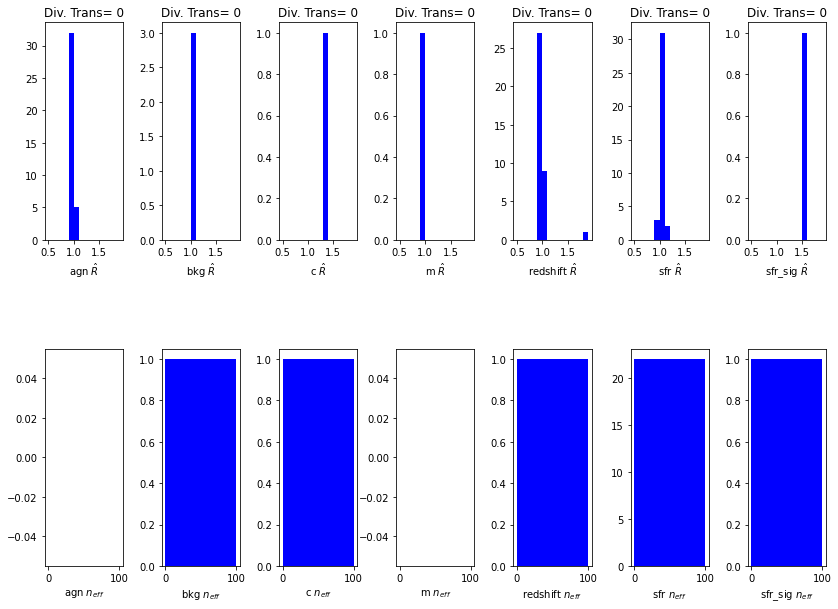

In [16]:
fig,axes=plt.subplots(2,len(samples),figsize=(2*len(samples),10))
for i,k in enumerate(samples):

    axes[0,i].hist(stats_summary[k]['r_hat'].flatten(),color='Blue',bins=np.arange(0.5,2,0.1))
    axes[1,i].hist(stats_summary[k]['n_eff'].flatten(),color='Blue',bins=np.arange(0,samples['m'].shape[0],100))
    axes[0,i].set_xlabel(k+' $ \hat{R}$')
    axes[0,i].set_title('Div. Trans= {}'.format(np.sum(divergences)))
    axes[1,i].set_xlabel(k+' $ n_{eff}$')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

All diagnostics look fine. 

## Posterior Probability distributions

#### Hierarchical parameters

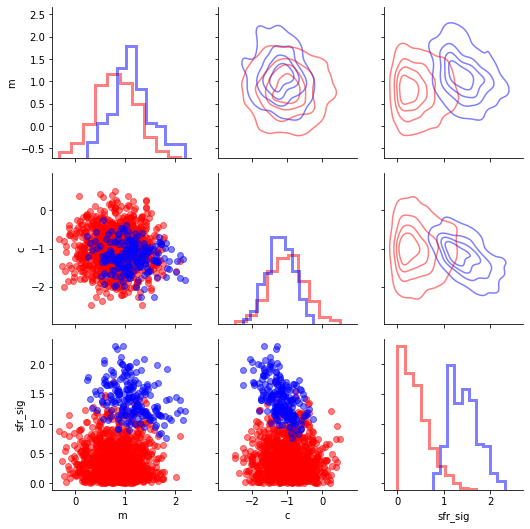

In [17]:
import pandas as pd
hier_param_names=['m','c','sfr_sig']

df_prior=pd.DataFrame(np.array([prior_pred[s] for s in hier_param_names]).T,columns=hier_param_names)
g=sns.PairGrid(df_prior)
g.map_lower(plt.scatter,alpha=0.5,color='Red')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Red',density=True)

df_post=pd.DataFrame(np.array([samples[s] for s in hier_param_names]).T,columns=hier_param_names)
g.data=df_post
g.map_lower(plt.scatter,alpha=0.5,color='Blue')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Blue',density=True)
g.map_upper(sns.kdeplot,alpha=0.5,color='Blue',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

#for some reason the contour plots will delete other plots so do last
g.data=df_prior
g.map_upper(sns.kdeplot,alpha=0.5,color='Red',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

#### Source parameters 

Text(0, 0.5, 'Redshift')

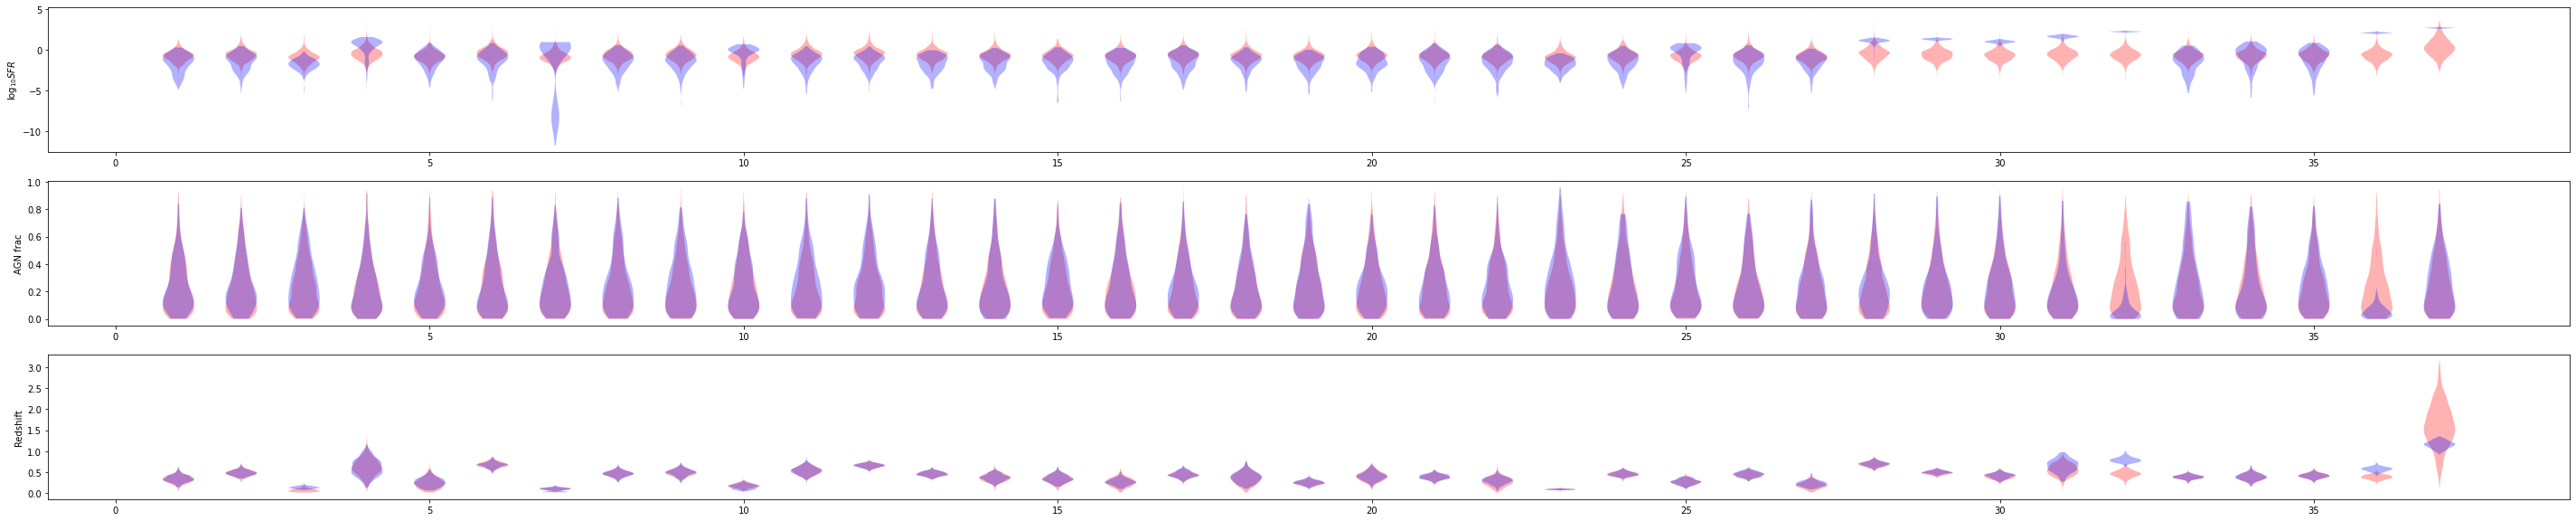

In [18]:
fig,axes=plt.subplots(3,1,figsize=(50,10))
phys_params=['sfr','agn','redshift']
for i ,p in enumerate(phys_params):
    v_plot=axes[i].violinplot(prior_pred[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Red')
    v_plot=axes[i].violinplot(samples[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Blue')

axes[0].set_ylabel('$\log_{10} SFR$')
axes[1].set_ylabel('AGN frac')
axes[2].set_ylabel('Redshift')

### Posterior Predicitive Checks

In [19]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive_samp=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = samples, num_samples = 50)
prior_pred_samp=prior_predictive_samp(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
mod_map_array_samp=[prior_pred_samp['obs_psw'].T,prior_pred_samp['obs_pmw'].T,prior_pred_samp['obs_plw'].T]

CPU times: user 2.33 s, sys: 6.05 ms, total: 2.33 s
Wall time: 2.31 s


In [20]:
#feed the model map arrays the animation function
xidplus.plots.make_map_animation(priors,mod_map_array_samp,50)

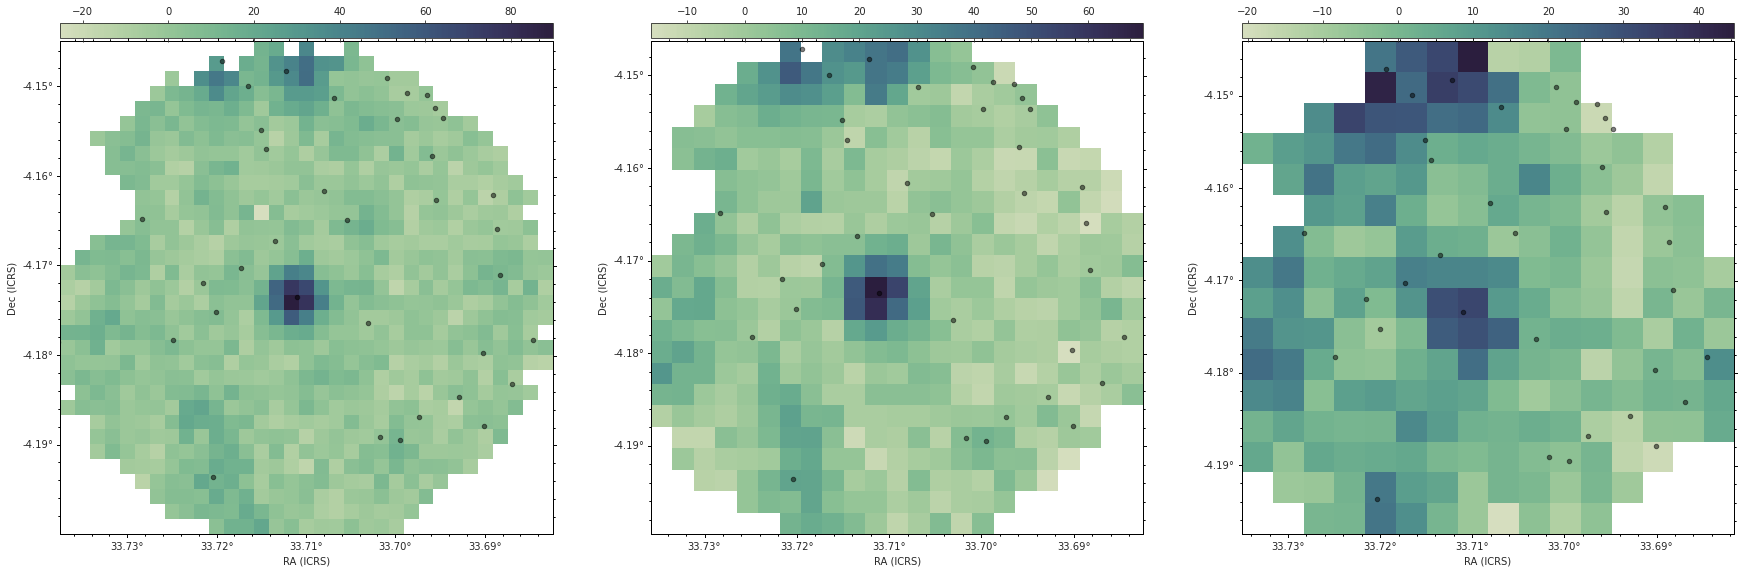

In [21]:
figures,fig=xidplus.plot_map(priors)

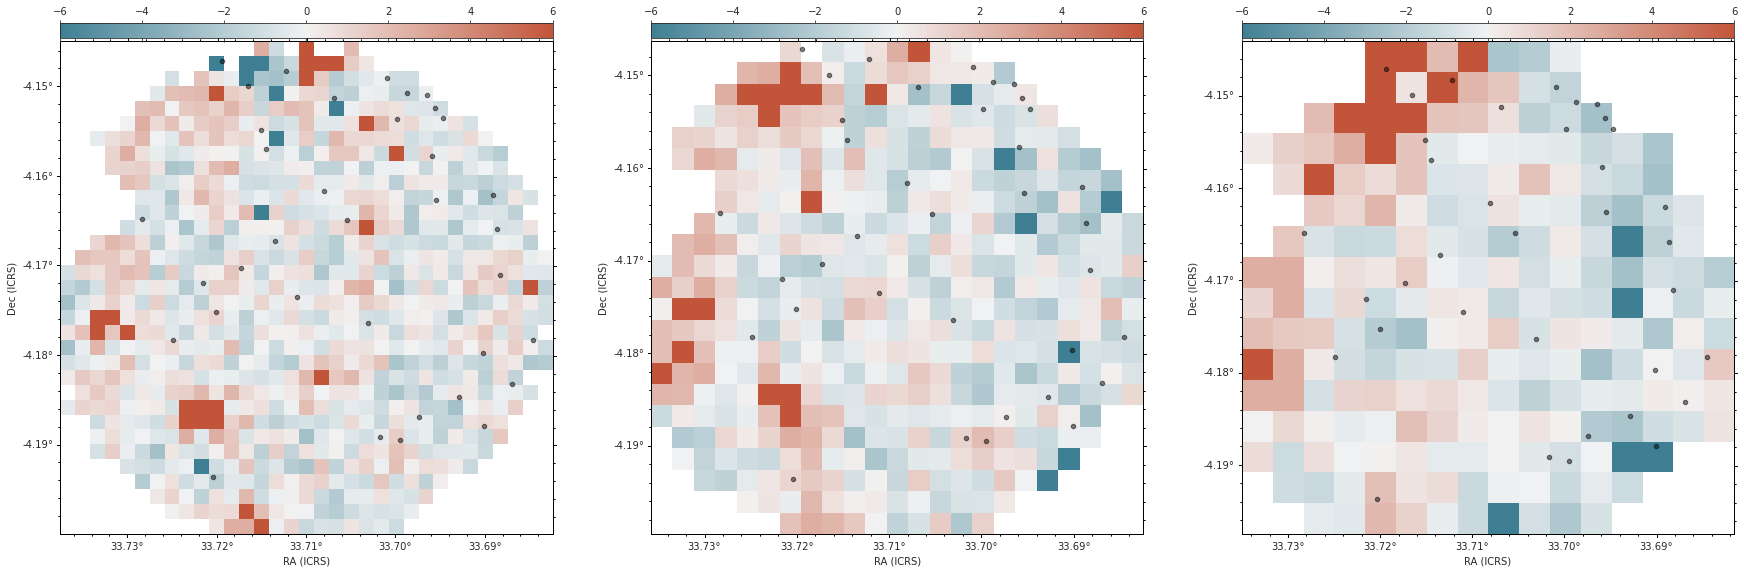

In [22]:
from xidplus import postmaps
import aplpy
sns.set_style("white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
Bayes_pvals = []
hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
fig = plt.figure(figsize=(10 * len(priors), 10))
figs = []
for i in range(0, len(priors)):
    figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
    Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))
    
    
for i in range(0, len(priors)):
    figs[i].show_markers(priors[i].sra, priors[i].sdec, edgecolor='black', facecolor='black',
                         marker='o', s=20, alpha=0.5)
    figs[i].tick_labels.set_xformat('dd.dd')
    figs[i].tick_labels.set_yformat('dd.dd')
    figs[i]._data[
        priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
    Bayes_pvals[i]
    figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
    figs[i].add_colorbar()
    figs[i].colorbar.set_location('top')

Read in the source we are interested in from Rowan-Robinsons's catalogue.

In [23]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import os

c = SkyCoord(ra=[esb['RA'][source[0]]]*u.degree, dec=[esb['Dec'][source[0]]]*u.degree)

In [24]:
#Run the DAOstarfinder on the original maps for all SPIRE bands
from photutils import DAOStarFinder
fwhm=[17.6,23.9,35.2]
new_scat_flux=[]
new_scat_pos=[]
for b in range(0,len(priors)):
    tmp_fits=postmaps.make_fits_image(priors[b],priors[b].sim)
    wcs_temp = wcs.WCS(tmp_fits[1].header)
    daofind = DAOStarFinder(fwhm=fwhm[b]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=5.0,sky=0.0,roundlo=- 10.0,roundhi= 10.0,sharplo=-5,sharphi=5)    
    new_scat = daofind(tmp_fits[1].data)
    new_scat_coords=wcs_temp.pixel_to_world(new_scat['xcentroid'],new_scat['ycentroid'])
    idx_new, d2d_new, d3d_new = c.match_to_catalog_sky(new_scat_coords)
    new_scat_flux.append(new_scat['peak'][idx_new])
    new_scat_pos.append(new_scat_coords[idx_new])


In [25]:
posterior_blind_source_coords=[]
posterior_blind_source_flux=[]
# Run starfinder on all posterior maps
for s in range(0,mod_map_array_samp[0].shape[-1]):
    if s%1000==0:
        print(s)
    tmp_posterior_blind_source_coords=[]
    tmp_posterior_blind_source_flux=[]
    for b in range(0,len(priors)):
        tmp_fits=postmaps.make_fits_image(priors[b],mod_map_array_samp[b][...,s])
        #need to widen constriants on roundness and sharpness constraints
        daofind = DAOStarFinder(fwhm=fwhm[b]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=5,sky=0.0,roundlo=- 10.0,roundhi= 10.0,sharplo=-5,sharphi=5) 
        sources = daofind(tmp_fits[1].data)
        #print(sources)
        wcs_temp = wcs.WCS(tmp_fits[1].header)
        new_coords=wcs_temp.pixel_to_world(sources['xcentroid'],sources['ycentroid'])
   
            
        idx_tmp, d2d_tmp, d3d_tmp = c.match_to_catalog_sky(new_coords)
        tmp_posterior_blind_source_coords.append(new_coords[idx_tmp])
        tmp_posterior_blind_source_flux.append(sources[idx_tmp]['peak'])
    posterior_blind_source_coords.append(tmp_posterior_blind_source_coords)
    posterior_blind_source_flux.append(tmp_posterior_blind_source_flux)
        
    

0


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [26]:
 # get original fluxes from scat
band=[250,350,500]
scat_flux=[]
scat_pos=[]
for b in band:
    scat=Table.read('../../../data/WP5-{}-SCAT{}-v1.0.fits.gz'.format(field[0],b))
    orig_scat_coords=SkyCoord(scat['RA'],scat['Dec'])
    idx, d2d, d3d = c.match_to_catalog_sky(orig_scat_coords)
    scat_flux.append(scat['F_SPIRE_{}'.format(b)][idx].data)
    scat_pos.append(orig_scat_coords[idx])
scat_flux=np.array(scat_flux)

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/WP5-XMM-LSS-SCAT250-v1.0.fits.gz'

In [ ]:
orig_map=xidplus.plot_map(priors)
for i in range(0,3):
    #plot new scat coords
    orig_map[0][i].show_markers(new_scat_pos[i].ra.value,new_scat_pos[i].dec.value,edgecolor='blue', facecolor='blue',
                marker='o', s=200, alpha=0.5)
    orig_map[0][i].show_markers(c.ra.value,c.dec.value, edgecolor='red', facecolor='red',
                marker='x', s=200, alpha=0.5)
    orig_map[0][i].show_markers(scat_pos[i].ra.value,scat_pos[i].dec.value,edgecolor='yellow', facecolor='yellow',
                marker='x', s=200, alpha=0.5)


In [ ]:
#stack params and make vector ready to be used by emualator
params = jnp.stack((samples['sfr'].T, samples['agn'].T, samples['redshift'].T)).T
# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params)))


#stack params and make vector ready to be used by emualator
params_prior = jnp.stack((prior_pred['sfr'].T, prior_pred['agn'].T, prior_pred['redshift'].T)).T
# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f_prior = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params_prior)))

In [ ]:
src_f.shape

In [ ]:
#find the sources that are within a certain separation of the extreme starburst candidate
sep=12
separation=new_scat_pos[0].separation(SkyCoord(priors[0].sra,priors[0].sdec)).arcsec
contrib_sources=separation<sep
print(' Sources \n {} \n are possible contributers to flux of extreme starburst'.format(priors[0].ID[contrib_sources]))

In [ ]:
cmap=sns.color_palette('colorblind')
sns.set_style("white")
#set up Pairgrid plot and plot blind source flux
df_blind=pd.DataFrame(np.array(posterior_blind_source_flux)[:,:,0],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g=sns.PairGrid(df_blind)
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='black')
#g.map_lower(sns.kdeplot, color="black",alpha=0.5,n_levels=10,density=True, shade=False,linewidth=3,shade_lowest=False)

#plot the fluxes for the possible sources that could contribute
for i in range(0,contrib_sources.sum()):
    df_tmp=pd.DataFrame(src_f[:,contrib_sources,:][:,i,:],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
    g.data=df_tmp
    g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color=cmap[i])
    #g.map_lower(sns.kdeplot, color=cmap[i],alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)

# plot the combination of flux from those sources
df_sum=pd.DataFrame(np.sum(src_f[:,contrib_sources,:],axis=1),columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g.data=df_sum
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='Red')




g.data=df_blind
g.map_lower(sns.kdeplot, color="black",alpha=0.5,n_levels=10,density=True, shade=False,linewidth=3,shade_lowest=False)
for i in range(0,contrib_sources.sum()):
    df_tmp=pd.DataFrame(src_f[:,contrib_sources,:][:,i,:],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
    g.data=df_tmp
    #g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color=cmap[i])
    g.map_lower(sns.kdeplot, color=cmap[i],alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)
g.data=df_sum
g.map_lower(sns.kdeplot, color='Red',alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)
    
    
#turn off the axes not used
g.axes[0,1].set_axis_off()
g.axes[0,2].set_axis_off()
g.axes[1,2].set_axis_off()

#plot the fluxes from new scat and orig scat
for i in range(0,len(priors)):
    g.axes[i,i].axvline(x=new_scat_flux[i],color='black')
    g.axes[i,i].axvline(x=scat_flux[i],color='green')
    for j in range(0,len(priors)):
        if j>i:
            g.axes[j,i].plot(new_scat_flux[i],new_scat_flux[j],'ko',ms=10)
            g.axes[j,i].plot(scat_flux[i],scat_flux[j],'go',ms=10)
#g.axes[2,0].plot(0.39,32.63,'ko',ms=10)
#g.axes[3,0].plot(0.39,27.0,'ko',ms=10)


### Parameters of contributing sources
The physical parameters of our sources which could be contributing to the extreme starburst

In [ ]:
phys_params=['sfr','agn','redshift']
contrib_params=pd.DataFrame(np.array([samples[p][:,contrib_sources].T for p in phys_params]).reshape((len(phys_params)*contrib_sources.sum(),-1)).T,
                            columns=np.concatenate([[s+'\n'+str(priors[0].ID[contrib_sources][i]).split("b'")[1] for i in range(0,contrib_sources.sum())] for s in phys_params])
)
contrib_params_prior=pd.DataFrame(np.array([prior_pred[p][:,contrib_sources].T for p in phys_params]).reshape((len(phys_params)*contrib_sources.sum(),-1)).T,
                            columns=np.concatenate([[s+'\n'+str(priors[0].ID[contrib_sources][i]).split("b'")[1] for i in range(0,contrib_sources.sum())] for s in phys_params])
)
g=sns.PairGrid(contrib_params)
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='Blue')
g.data=contrib_params_prior
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='Red')
g.map_lower(sns.kdeplot, color='Red',alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)

g.data=contrib_params
g.map_lower(sns.kdeplot, color='Blue',alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)

[a.axhline(y=esb[source[0]]['Z\xa0comb'],color='black') for a in g.axes[-1,:-1]]
g.axes[1,0].axhline(y=esb[source[0]]['SFR log(M\xa0sol. yr−1)'],color='black') 

g.axes[-1,-1].axvline(x=esb[source[0]]['Z\xa0comb'],color='black')
[a.axvline(x=esb[source[0]]['SFR log(M\xa0sol. yr−1)'],color='black') for a in g.axes[1:,1]]



update the webtable to identify issues

In [ ]:
esb_web=Table.read('../../../data/MRR2018_tables/{}_web.csv'.format(field[0]),format='ascii',encoding='utf-8')
if np.sum(divergences)<1:
    esb_web['status'][source[0]]='[- [ x ]](./output/{}/fit_{}.md)'.format(field[0],source[0]+1)
    esb_web.write('../../../data/MRR2018_tables/{}_web.csv'.format(field[0]),format='ascii',overwrite=True)
else:
    esb_web['status'][source[0]]='[- [  ]](./output/{}/fit_{}.md)'.format(field[0],source[0]+1)
    esb_web.write('../../../data/MRR2018_tables/{}_web.csv'.format(field[0]),format='ascii',overwrite=True)